In [ ]:
import numpy as np
import os
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from IPython.display import display, Image


In [ ]:
class ReLU:
    """ReLU Activation"""
    def forward(self, x):
        self.out = np.maximum(0, x)
        return self.out

    def backward(self, grad_output):
        grad_input = grad_output * (self.out > 0)
        return grad_input

class Tanh:
    """Tanh Activation"""
    def forward(self, x):
        self.out = np.tanh(x)
        return self.out

    def backward(self, grad_output):
        grad_input = grad_output * (1 - self.out**2)
        return grad_input

class Sigmoid:
    """Sigmoid Activation"""
    def forward(self, x):
        self.out = 1 / (1 + np.exp(-x))
        return self.out

    def backward(self, grad_output):
        grad_input = grad_output * self.out * (1 - self.out)
        return grad_input

class Identity:
    def __init__(self):
        pass

    def forward(self, x):
        self.input = x
        return x

    def backward(self, grad_output):
        return grad_output

    def update(self, lr):
        pass

    def zero_grad(self):
        pass  # nothing to reset, but must exist for consistency

    def __repr__(self):
        return "Identity()"


In [ ]:
class Linear:
    """Fully Connected Layer"""
    def __init__(self, in_features, out_features, activation):
        self.in_features = in_features
        self.out_features = out_features
        self.activation = activation

        # Initialize weights and biases
        self.W = np.random.randn(in_features, out_features) * np.sqrt(2.0 / in_features)
        self.b = np.zeros((1, out_features))

        # Cumulative gradients
        self.dW_cum = np.zeros_like(self.W)
        self.db_cum = np.zeros_like(self.b)

    def forward(self, x):
        self.input = x  # Save for backward
        self.linear_out = x @ self.W + self.b
        self.out = self.activation.forward(self.linear_out)
        return self.out

    def backward(self, grad_output):
        # Gradient w.r.t activation
        grad_activation = self.activation.backward(grad_output)
        # Gradients w.r.t weights and biases
        self.dW_cum += self.input.T @ grad_activation
        self.db_cum += np.sum(grad_activation, axis=0, keepdims=True)
        # Gradient w.r.t input for previous layer
        grad_input = grad_activation @ self.W.T
        return grad_input

    def zero_grad(self):
        self.dW_cum.fill(0)
        self.db_cum.fill(0)

    def update(self, lr=0.01):
        self.W -= lr * self.dW_cum
        self.b -= lr * self.db_cum
        self.zero_grad()


In [ ]:
class Model:
    """Neural Network Model"""
    def __init__(self, layers, loss_type="MSE"):
        self.layers = layers
        self.loss_type = loss_type

    def forward(self, x):
        out = x
        for layer in self.layers:
            out = layer.forward(out)
        return out

    def backward(self, grad):
        for layer in reversed(self.layers):
            grad = layer.backward(grad)

    def train(self, x, y):
        """Forward + backward pass, returns scalar loss"""
        y_pred = self.forward(x)
        # Compute loss
        if self.loss_type == "MSE":
            loss = np.mean((y_pred - y) ** 2)
            grad_loss = 2 * (y_pred - y) / y.shape[0]
        elif self.loss_type == "BCE":
            eps = 1e-9
            y_pred = np.clip(y_pred, eps, 1 - eps)
            loss = -np.mean(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))
            grad_loss = (y_pred - y) / (y_pred * (1 - y_pred)) / y.shape[0]
        else:
            raise ValueError("Unknown loss type")

        self.backward(grad_loss)
        return float(loss)

    def zero_grad(self):
        for layer in self.layers:
            layer.zero_grad()

    def update(self, lr=0.01):
        for layer in self.layers:
            layer.update(lr=lr)

    def predict(self, x):
        return self.forward(x)

    def save_to(self, path):
        data = {}
        for idx, layer in enumerate(self.layers):
            # only save layers that have weights
            if hasattr(layer, "W") and hasattr(layer, "b"):
                data[f"W_{idx}"] = layer.W
                data[f"b_{idx}"] = layer.b
        np.savez(path, **data)

    def load_from(self, path):
        loaded = np.load(path)
        for idx, layer in enumerate(self.layers):
            w_key = f"W_{idx}"
            b_key = f"b_{idx}"
            if w_key not in loaded or b_key not in loaded:
                raise ValueError("Architecture mismatch!")
            if layer.W.shape != loaded[w_key].shape or layer.b.shape != loaded[b_key].shape:
                raise ValueError("Shape mismatch!")
            layer.W = loaded[w_key]
            layer.b = loaded[b_key]


In [ ]:
def train_model(model, X_train, y_train, batch_size=32, grad_accum_steps=1,
                num_epochs=500, patience=10, rel_loss_thresh=0.01, lr=0.01):
    """
    Train model and plot Loss vs Samples Seen.
    Returns (loss_history, run_dir)
    """
    cwd = os.getcwd()
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    run_dir = os.path.join(cwd, "runs", timestamp)
    os.makedirs(run_dir, exist_ok=True)

    num_samples = X_train.shape[0]
    loss_history = []
    samples_seen = []
    total_samples_seen = 0
    best_loss = np.inf
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        indices = np.random.permutation(num_samples)
        X_shuffled = X_train[indices]
        y_shuffled = y_train[indices]

        epoch_loss = 0.0
        batch_counter = 0
        num_batches = int(np.ceil(num_samples / batch_size))

        with tqdm(total=num_batches, desc=f"Epoch {epoch+1}/{num_epochs}") as pbar:
            for i in range(0, num_samples, batch_size):
                X_batch = X_shuffled[i:i+batch_size]
                y_batch = y_shuffled[i:i+batch_size]

                if batch_counter % grad_accum_steps == 0:
                    model.zero_grad()

                batch_loss = model.train(X_batch, y_batch)
                epoch_loss += batch_loss
                total_samples_seen += len(X_batch)
                loss_history.append(batch_loss)
                samples_seen.append(total_samples_seen)
                batch_counter += 1

                if batch_counter % grad_accum_steps == 0:
                    model.update(lr=lr)

                pbar.set_postfix({"loss": f"{batch_loss:.4f}"})
                pbar.update(1)

        avg_epoch_loss = epoch_loss / num_batches

        # Early stopping
        if avg_epoch_loss < best_loss * (1 - rel_loss_thresh):
            best_loss = avg_epoch_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            break

    # Save model
    model_path = os.path.join(run_dir, "model_final.npz")
    model.save_to(model_path)

    # Plot Loss vs Samples Seen
    plt.figure(figsize=(8,5))
    sns.lineplot(x=samples_seen, y=loss_history, label="Training Loss")
    plt.xlabel("Samples Seen")
    plt.ylabel("Loss")
    plt.title("Training Loss vs Samples Seen")
    plt.grid(True)
    plt.tight_layout()

    plot_path = os.path.join(run_dir, "loss_vs_samples.png")
    plt.savefig(plot_path)
    plt.show()

    from IPython.display import Image as IPyImage, display
    display(IPyImage(filename=plot_path))

    return loss_history, run_dir


# 3.1

In [ ]:
# Cell 1 - Import Libraries and Load MNIST Dataset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os
from datetime import datetime

# Set random seed for reproducibility
np.random.seed(42)

print("Loading MNIST dataset...")
# Load MNIST dataset
mnist = fetch_openml('mnist_784', version=1, parser='auto')
X = mnist.data.values if hasattr(mnist.data, 'values') else mnist.data
y = mnist.target.values if hasattr(mnist.target, 'values') else mnist.target

# Normalize pixel values to [0, 1]
X = X.astype(np.float32) / 255.0

# Convert labels to integers
y = y.astype(int)

print(f"Dataset loaded successfully!")
print(f"Total samples: {X.shape[0]}")
print(f"Feature dimension: {X.shape[1]}")
print(f"Image shape: 28x28")
print(f"Number of classes: {len(np.unique(y))}")

# Split into train and test sets (MNIST already has standard split)
# First 60000 samples are training, rest are test
X_train = X[:60000]
y_train = y[:60000]
X_test = X[60000:]
y_test = y[60000:]

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

In [ ]:
# Cell 2 - Visualize Sample MNIST Images
def visualize_mnist_samples(X, y, n_samples=10, title="MNIST Sample Images"):
    """
    Visualize random samples from MNIST dataset.
    
    Parameters:
    -----------
    X : np.ndarray
        Image data (N, 784)
    y : np.ndarray
        Labels (N,)
    n_samples : int
        Number of samples to display
    title : str
        Plot title
    """
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))
    axes = axes.flatten()
    
    # Randomly select samples
    indices = np.random.choice(len(X), n_samples, replace=False)
    
    for idx, ax in enumerate(axes):
        img = X[indices[idx]].reshape(28, 28)
        ax.imshow(img, cmap='gray')
        ax.set_title(f'Label: {y[indices[idx]]}', fontsize=11)
        ax.axis('off')
    
    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Visualize training samples
visualize_mnist_samples(X_train, y_train, n_samples=10, 
                        title="Random Training Samples from MNIST")

In [ ]:
# Cell 3 - MLPAutoencoder Class Implementation
class MLPAutoencoder:
    """
    Multi-Layer Perceptron Autoencoder for image reconstruction.
    
    Uses encoder to compress input to latent representation,
    and decoder to reconstruct input from latent representation.
    """
    
    def __init__(self, input_dim=784, hidden_dims=[256, 128], latent_dim=64):
        """
        Initialize MLPAutoencoder.
        
        Parameters:
        -----------
        input_dim : int
            Dimension of input (e.g., 784 for 28x28 images)
        hidden_dims : list of int
            Hidden layer dimensions for encoder
        latent_dim : int
            Dimension of latent bottleneck representation
        """
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.latent_dim = latent_dim
        
        # Build encoder layers
        self.encoder_layers = []
        prev_dim = input_dim
        
        # Hidden layers in encoder
        for hidden_dim in hidden_dims:
            self.encoder_layers.append(Linear(prev_dim, hidden_dim, ReLU()))
            prev_dim = hidden_dim
        
        # Bottleneck layer (encoder output)
        self.encoder_layers.append(Linear(prev_dim, latent_dim, ReLU()))
        
        # Build decoder layers (mirror of encoder)
        self.decoder_layers = []
        prev_dim = latent_dim
        
        # Hidden layers in decoder (reverse order)
        for hidden_dim in reversed(hidden_dims):
            self.decoder_layers.append(Linear(prev_dim, hidden_dim, ReLU()))
            prev_dim = hidden_dim
        
        # Output layer (decoder output) - use Sigmoid to constrain to [0, 1]
        self.decoder_layers.append(Linear(prev_dim, input_dim, Sigmoid()))
        
        # Combine all layers
        self.all_layers = self.encoder_layers + self.decoder_layers
        
    def encode(self, x):
        """
        Encode input to latent representation.
        
        Parameters:
        -----------
        x : np.ndarray
            Input data (N, input_dim)
            
        Returns:
        --------
        np.ndarray
            Latent representation (N, latent_dim)
        """
        out = x
        for layer in self.encoder_layers:
            out = layer.forward(out)
        return out
    
    def decode(self, z):
        """
        Decode latent representation to reconstructed input.
        
        Parameters:
        -----------
        z : np.ndarray
            Latent representation (N, latent_dim)
            
        Returns:
        --------
        np.ndarray
            Reconstructed input (N, input_dim)
        """
        out = z
        for layer in self.decoder_layers:
            out = layer.forward(out)
        return out
    
    def forward(self, x):
        """
        Full forward pass: encode then decode.
        
        Parameters:
        -----------
        x : np.ndarray
            Input data (N, input_dim)
            
        Returns:
        --------
        np.ndarray
            Reconstructed input (N, input_dim)
        """
        # Encode
        latent = self.encode(x)
        # Decode
        reconstructed = self.decode(latent)
        return reconstructed
    
    def backward(self, grad_output):
        """
        Backward pass through entire autoencoder.
        
        Parameters:
        -----------
        grad_output : np.ndarray
            Gradient of loss w.r.t. output
        """
        grad = grad_output
        for layer in reversed(self.all_layers):
            grad = layer.backward(grad)
    
    def zero_grad(self):
        """Reset all gradients to zero."""
        for layer in self.all_layers:
            layer.zero_grad()
    
    def update(self, lr=0.01):
        """
        Update all parameters using accumulated gradients.
        
        Parameters:
        -----------
        lr : float
            Learning rate
        """
        for layer in self.all_layers:
            layer.update(lr=lr)
    
    def train_step(self, x):
        """
        Single training step: forward, compute loss, backward.
        
        Parameters:
        -----------
        x : np.ndarray
            Input batch (N, input_dim)
            
        Returns:
        --------
        float
            Reconstruction loss (MSE)
        """
        # Forward pass
        x_reconstructed = self.forward(x)
        
        # Compute MSE loss
        loss = np.mean((x_reconstructed - x) ** 2)
        
        # Compute gradient of loss w.r.t. output
        grad_loss = 2 * (x_reconstructed - x) / x.shape[0]
        
        # Backward pass
        self.backward(grad_loss)
        
        return float(loss)
    
    def get_architecture_summary(self):
        """Return string summary of autoencoder architecture."""
        summary = "=" * 70 + "\n"
        summary += "MLPAutoencoder Architecture\n"
        summary += "=" * 70 + "\n"
        summary += f"Input Dimension: {self.input_dim}\n"
        summary += f"Latent Dimension: {self.latent_dim}\n"
        summary += f"Hidden Dimensions: {self.hidden_dims}\n\n"
        
        summary += "Encoder:\n"
        summary += "-" * 70 + "\n"
        prev_dim = self.input_dim
        for i, dim in enumerate(self.hidden_dims):
            summary += f"  Layer {i+1}: Linear({prev_dim} → {dim}) + ReLU\n"
            prev_dim = dim
        summary += f"  Bottleneck: Linear({prev_dim} → {self.latent_dim}) + ReLU\n\n"
        
        summary += "Decoder:\n"
        summary += "-" * 70 + "\n"
        prev_dim = self.latent_dim
        for i, dim in enumerate(reversed(self.hidden_dims)):
            summary += f"  Layer {i+1}: Linear({prev_dim} → {dim}) + ReLU\n"
            prev_dim = dim
        summary += f"  Output: Linear({prev_dim} → {self.input_dim}) + Sigmoid\n"
        
        summary += "=" * 70
        return summary

# Create autoencoder instance
autoencoder = MLPAutoencoder(
    input_dim=784,
    hidden_dims=[256, 128],
    latent_dim=64
)

# Print architecture summary
print(autoencoder.get_architecture_summary())

In [14]:
# Cell 4 - Training Function with Visualization
def train_autoencoder(autoencoder, X_train, X_test, batch_size=128, num_epochs=20, 
                      lr=0.001, patience=5, rel_loss_thresh=0.01):
    """
    Train the autoencoder on MNIST dataset.
    
    Parameters:
    -----------
    autoencoder : MLPAutoencoder
        The autoencoder model to train
    X_train : np.ndarray
        Training data (N, 784)
    X_test : np.ndarray
        Test data (M, 784)
    batch_size : int
        Batch size for training
    num_epochs : int
        Maximum number of epochs
    lr : float
        Learning rate
    patience : int
        Early stopping patience
    rel_loss_thresh : float
        Relative improvement threshold for early stopping
        
    Returns:
    --------
    dict
        Dictionary containing training history and metadata
    """
    num_samples = X_train.shape[0]
    train_loss_history = []
    test_loss_history = []
    epoch_list = []
    
    best_loss = np.inf
    epochs_no_improve = 0
    
    print("=" * 80)
    print("TRAINING AUTOENCODER")
    print("=" * 80)
    print(f"Training samples: {num_samples}")
    print(f"Batch size: {batch_size}")
    print(f"Learning rate: {lr}")
    print(f"Max epochs: {num_epochs}")
    print("=" * 80 + "\n")
    
    for epoch in range(num_epochs):
        # Shuffle training data
        indices = np.random.permutation(num_samples)
        X_shuffled = X_train[indices]
        
        epoch_loss = 0.0
        num_batches = int(np.ceil(num_samples / batch_size))
        
        # Training loop
        for i in range(0, num_samples, batch_size):
            X_batch = X_shuffled[i:i+batch_size]
            
            # Zero gradients
            autoencoder.zero_grad()
            
            # Forward pass and compute loss
            batch_loss = autoencoder.train_step(X_batch)
            
            # Update parameters
            autoencoder.update(lr=lr)
            
            epoch_loss += batch_loss
        
        # Average training loss for epoch
        avg_train_loss = epoch_loss / num_batches
        train_loss_history.append(avg_train_loss)
        
        # Compute test loss
        test_loss = 0.0
        num_test_batches = int(np.ceil(X_test.shape[0] / batch_size))
        for i in range(0, X_test.shape[0], batch_size):
            X_test_batch = X_test[i:i+batch_size]
            X_test_reconstructed = autoencoder.forward(X_test_batch)
            test_loss += np.mean((X_test_reconstructed - X_test_batch) ** 2)
        
        avg_test_loss = test_loss / num_test_batches
        test_loss_history.append(avg_test_loss)
        
        epoch_list.append(epoch + 1)
        
        # Print progress
        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Train Loss: {avg_train_loss:.6f} - "
              f"Test Loss: {avg_test_loss:.6f}")
        
        # Early stopping check
        if avg_train_loss < best_loss * (1 - rel_loss_thresh):
            best_loss = avg_train_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        
        if epochs_no_improve >= patience:
            print(f"\nEarly stopping triggered at epoch {epoch+1}")
            break
    
    print("\n" + "=" * 80)
    print("TRAINING COMPLETED")
    print("=" * 80)
    print(f"Final Train Loss: {train_loss_history[-1]:.6f}")
    print(f"Final Test Loss: {test_loss_history[-1]:.6f}")
    print(f"Best Train Loss: {min(train_loss_history):.6f}")
    print(f"Best Test Loss: {min(test_loss_history):.6f}")
    print("=" * 80)
    
    return {
        'train_loss': train_loss_history,
        'test_loss': test_loss_history,
        'epochs': epoch_list,
        'best_train_loss': min(train_loss_history),
        'best_test_loss': min(test_loss_history)
    }

# Train the autoencoder
training_history = train_autoencoder(
    autoencoder=autoencoder,
    X_train=X_train,
    X_test=X_test,
    batch_size=128,
    num_epochs=20,
    lr=0.001,
    patience=5,
    rel_loss_thresh=0.01
)

Epoch 1/20 - Train Loss: 0.087357 - Test Loss: 0.066159
Epoch 2/20 - Train Loss: 0.059564 - Test Loss: 0.053486
Epoch 3/20 - Train Loss: 0.049526 - Test Loss: 0.045484
Epoch 4/20 - Train Loss: 0.043647 - Test Loss: 0.040909
Epoch 5/20 - Train Loss: 0.039622 - Test Loss: 0.037012
Epoch 6/20 - Train Loss: 0.036577 - Test Loss: 0.034591
Epoch 7/20 - Train Loss: 0.034010 - Test Loss: 0.032363
Epoch 8/20 - Train Loss: 0.031887 - Test Loss: 0.030320
Epoch 9/20 - Train Loss: 0.030269 - Test Loss: 0.028689
Epoch 10/20 - Train Loss: 0.028917 - Test Loss: 0.027785
Epoch 11/20 - Train Loss: 0.027776 - Test Loss: 0.026508
Epoch 12/20 - Train Loss: 0.026801 - Test Loss: 0.025719
Epoch 13/20 - Train Loss: 0.025909 - Test Loss: 0.025395
Epoch 14/20 - Train Loss: 0.025197 - Test Loss: 0.024484
Epoch 15/20 - Train Loss: 0.024583 - Test Loss: 0.023451
Epoch 16/20 - Train Loss: 0.023980 - Test Loss: 0.023952
Epoch 17/20 - Train Loss: 0.023523 - Test Loss: 0.022720
Epoch 18/20 - Train Loss: 0.023045 - Tes

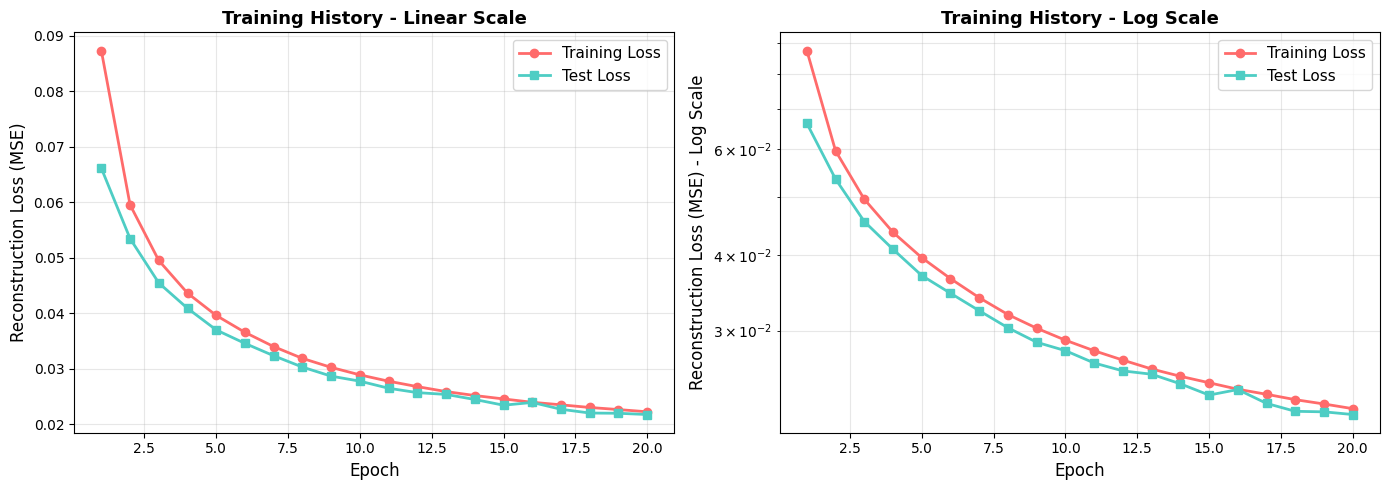

In [15]:
# Cell 5 - Plot Training History
def plot_training_history(history, save_path=None):
    """
    Plot training and test loss over epochs.
    
    Parameters:
    -----------
    history : dict
        Dictionary containing training history
    save_path : str, optional
        Path to save the plot
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    epochs = history['epochs']
    train_loss = history['train_loss']
    test_loss = history['test_loss']
    
    # Linear scale plot
    axes[0].plot(epochs, train_loss, 'o-', linewidth=2, markersize=6, 
                label='Training Loss', color='#FF6B6B')
    axes[0].plot(epochs, test_loss, 's-', linewidth=2, markersize=6, 
                label='Test Loss', color='#4ECDC4')
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Reconstruction Loss (MSE)', fontsize=12)
    axes[0].set_title('Training History - Linear Scale', fontsize=13, fontweight='bold')
    axes[0].legend(fontsize=11)
    axes[0].grid(True, alpha=0.3)
    
    # Log scale plot
    axes[1].plot(epochs, train_loss, 'o-', linewidth=2, markersize=6, 
                label='Training Loss', color='#FF6B6B')
    axes[1].plot(epochs, test_loss, 's-', linewidth=2, markersize=6, 
                label='Test Loss', color='#4ECDC4')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Reconstruction Loss (MSE) - Log Scale', fontsize=12)
    axes[1].set_title('Training History - Log Scale', fontsize=13, fontweight='bold')
    axes[1].legend(fontsize=11)
    axes[1].grid(True, alpha=0.3, which='both')
    axes[1].set_yscale('log')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Plot saved to: {save_path}")
    
    plt.show()

# Plot training history
plot_training_history(training_history)

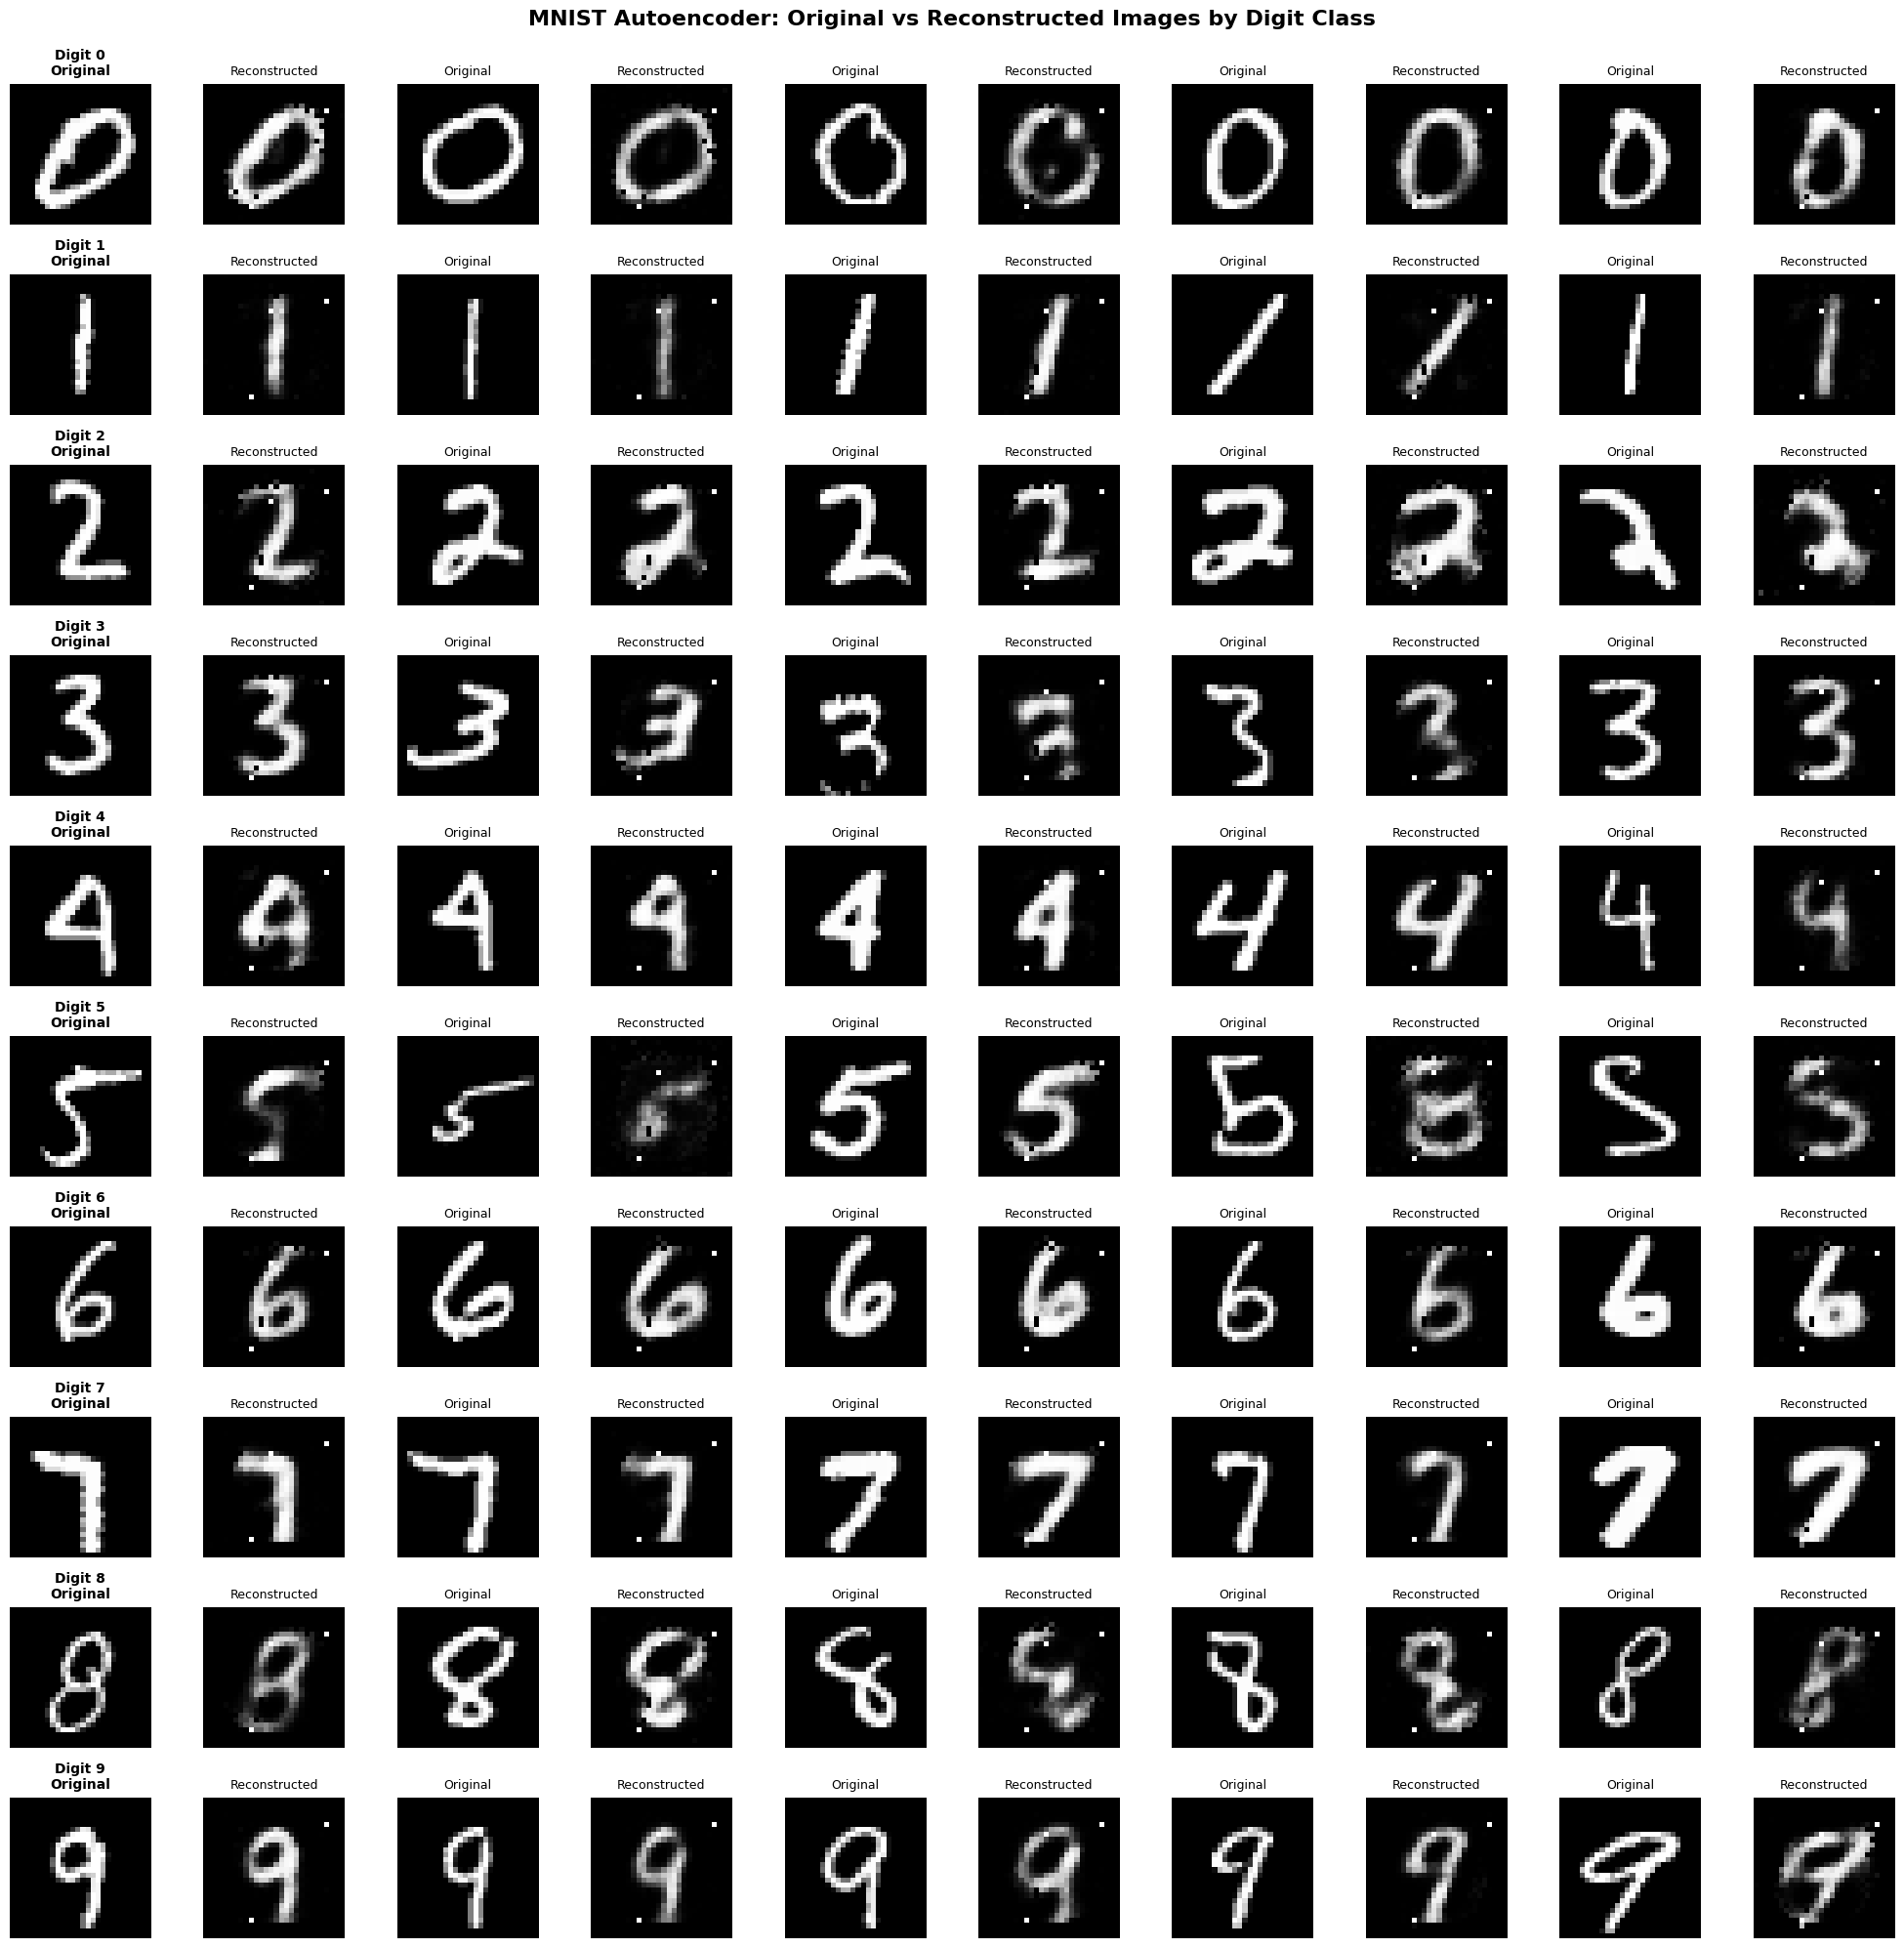

In [16]:
# Cell 6 - Visualization Function for Reconstructions
def visualize_reconstructions_by_digit(autoencoder, X_test, y_test, 
                                       n_samples_per_digit=5, save_path=None):
    """
    Visualize original and reconstructed images for each digit class (0-9).
    
    Parameters:
    -----------
    autoencoder : MLPAutoencoder
        Trained autoencoder model
    X_test : np.ndarray
        Test images (N, 784)
    y_test : np.ndarray
        Test labels (N,)
    n_samples_per_digit : int
        Number of samples to show per digit
    save_path : str, optional
        Path to save the visualization
    """
    fig, axes = plt.subplots(10, 2 * n_samples_per_digit, 
                            figsize=(2 * n_samples_per_digit * 2, 20))
    
    for digit in range(10):
        # Get indices for this digit
        digit_indices = np.where(y_test == digit)[0]
        
        # Randomly select n_samples_per_digit
        selected_indices = np.random.choice(digit_indices, 
                                           n_samples_per_digit, 
                                           replace=False)
        
        for idx, sample_idx in enumerate(selected_indices):
            # Get original image
            original = X_test[sample_idx:sample_idx+1]
            
            # Get reconstruction
            reconstructed = autoencoder.forward(original)
            
            # Reshape for display
            original_img = original.reshape(28, 28)
            reconstructed_img = reconstructed.reshape(28, 28)
            
            # Plot original
            col_orig = 2 * idx
            axes[digit, col_orig].imshow(original_img, cmap='gray')
            axes[digit, col_orig].axis('off')
            if idx == 0:
                axes[digit, col_orig].set_title(f'Digit {digit}\nOriginal', 
                                               fontsize=10, fontweight='bold')
            else:
                axes[digit, col_orig].set_title('Original', fontsize=9)
            
            # Plot reconstruction
            col_recon = 2 * idx + 1
            axes[digit, col_recon].imshow(reconstructed_img, cmap='gray')
            axes[digit, col_recon].axis('off')
            axes[digit, col_recon].set_title('Reconstructed', fontsize=9)
    
    plt.suptitle('MNIST Autoencoder: Original vs Reconstructed Images by Digit Class', 
                fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Visualization saved to: {save_path}")
    
    plt.show()

# Visualize reconstructions for each digit
visualize_reconstructions_by_digit(
    autoencoder=autoencoder,
    X_test=X_test,
    y_test=y_test,
    n_samples_per_digit=5
)

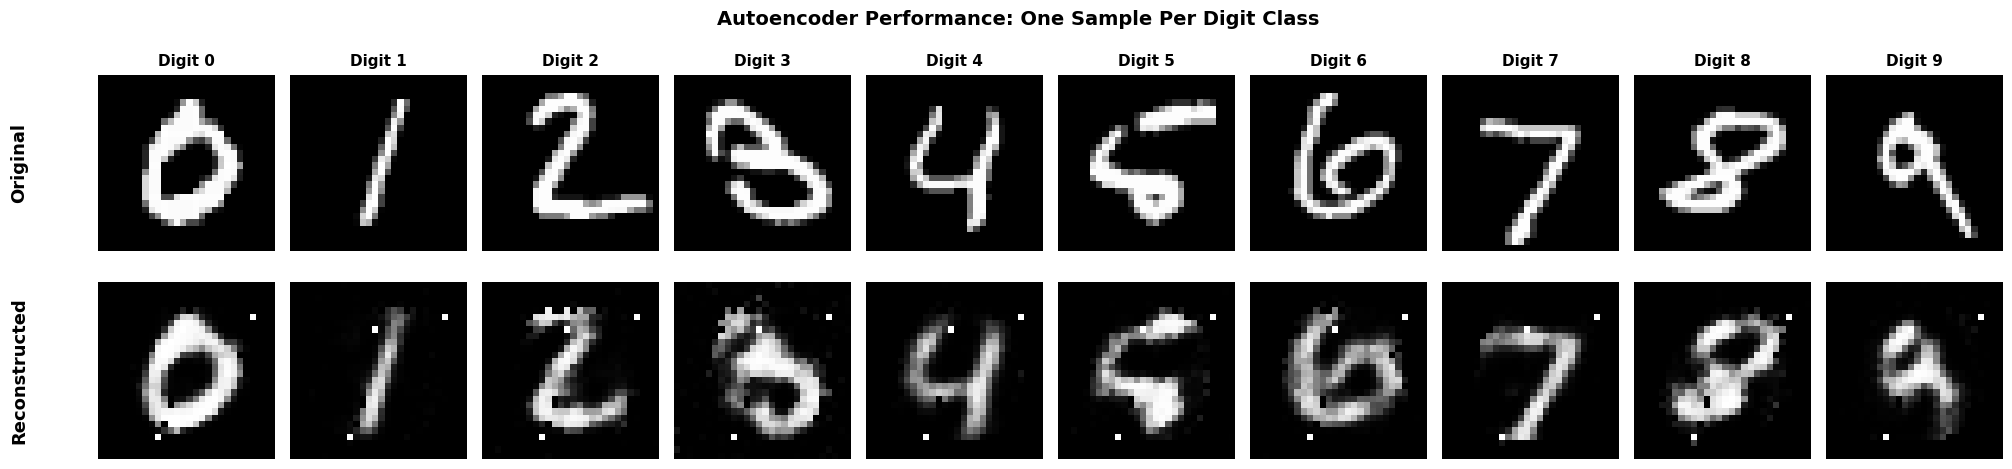

In [17]:
# Cell 7 - Alternative Compact Visualization (One Sample Per Digit)
def visualize_single_reconstruction_per_digit(autoencoder, X_test, y_test, save_path=None):
    """
    Visualize one original and reconstructed image for each digit class (0-9).
    
    Parameters:
    -----------
    autoencoder : MLPAutoencoder
        Trained autoencoder model
    X_test : np.ndarray
        Test images (N, 784)
    y_test : np.ndarray
        Test labels (N,)
    save_path : str, optional
        Path to save the visualization
    """
    fig, axes = plt.subplots(2, 10, figsize=(20, 5))
    
    for digit in range(10):
        # Get first occurrence of this digit
        digit_idx = np.where(y_test == digit)[0][0]
        
        # Get original image
        original = X_test[digit_idx:digit_idx+1]
        
        # Get reconstruction
        reconstructed = autoencoder.forward(original)
        
        # Reshape for display
        original_img = original.reshape(28, 28)
        reconstructed_img = reconstructed.reshape(28, 28)
        
        # Plot original (top row)
        axes[0, digit].imshow(original_img, cmap='gray')
        axes[0, digit].set_title(f'Digit {digit}', fontsize=11, fontweight='bold')
        axes[0, digit].axis('off')
        
        # Plot reconstruction (bottom row)
        axes[1, digit].imshow(reconstructed_img, cmap='gray')
        axes[1, digit].axis('off')
    
    # Add row labels
    axes[0, 0].text(-0.5, 0.5, 'Original', fontsize=13, fontweight='bold',
                   rotation=90, transform=axes[0, 0].transAxes,
                   verticalalignment='center')
    axes[1, 0].text(-0.5, 0.5, 'Reconstructed', fontsize=13, fontweight='bold',
                   rotation=90, transform=axes[1, 0].transAxes,
                   verticalalignment='center')
    
    plt.suptitle('Autoencoder Performance: One Sample Per Digit Class', 
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Visualization saved to: {save_path}")
    
    plt.show()

# Visualize one sample per digit
visualize_single_reconstruction_per_digit(
    autoencoder=autoencoder,
    X_test=X_test,
    y_test=y_test
)


RECONSTRUCTION ERROR BY DIGIT CLASS
Digit 0: 0.022813
Digit 1: 0.009787
Digit 2: 0.030277
Digit 3: 0.023227
Digit 4: 0.021050
Digit 5: 0.024502
Digit 6: 0.025148
Digit 7: 0.019459
Digit 8: 0.026286
Digit 9: 0.017436


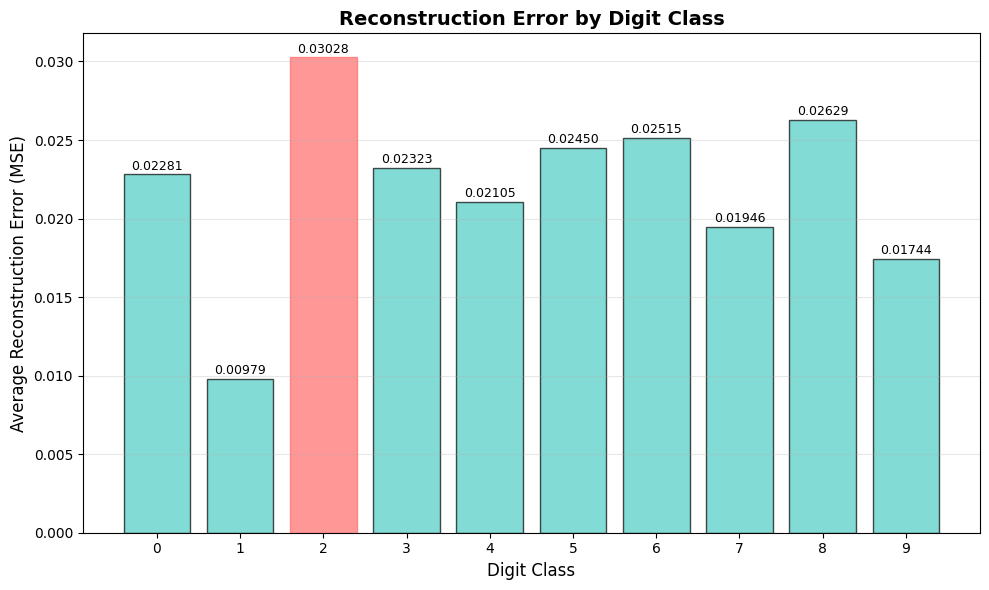

In [18]:
# Cell 8 - Compute and Visualize Reconstruction Error by Digit
def compute_reconstruction_error_by_digit(autoencoder, X_test, y_test):
    """
    Compute average reconstruction error for each digit class.
    
    Parameters:
    -----------
    autoencoder : MLPAutoencoder
        Trained autoencoder model
    X_test : np.ndarray
        Test images (N, 784)
    y_test : np.ndarray
        Test labels (N,)
        
    Returns:
    --------
    dict
        Dictionary mapping digit to average reconstruction error
    """
    reconstruction_errors = {}
    
    for digit in range(10):
        # Get all samples for this digit
        digit_indices = np.where(y_test == digit)[0]
        X_digit = X_test[digit_indices]
        
        # Get reconstructions
        X_reconstructed = autoencoder.forward(X_digit)
        
        # Compute MSE for each sample
        mse_per_sample = np.mean((X_reconstructed - X_digit) ** 2, axis=1)
        
        # Average over all samples of this digit
        avg_error = np.mean(mse_per_sample)
        reconstruction_errors[digit] = avg_error
    
    return reconstruction_errors

def plot_reconstruction_error_by_digit(reconstruction_errors, save_path=None):
    """
    Plot average reconstruction error for each digit class.
    
    Parameters:
    -----------
    reconstruction_errors : dict
        Dictionary mapping digit to reconstruction error
    save_path : str, optional
        Path to save the plot
    """
    digits = list(reconstruction_errors.keys())
    errors = list(reconstruction_errors.values())
    
    plt.figure(figsize=(10, 6))
    
    bars = plt.bar(digits, errors, color='#4ECDC4', edgecolor='black', alpha=0.7)
    
    # Color the bar with highest error differently
    max_error_digit = max(reconstruction_errors, key=reconstruction_errors.get)
    bars[max_error_digit].set_color('#FF6B6B')
    
    plt.xlabel('Digit Class', fontsize=12)
    plt.ylabel('Average Reconstruction Error (MSE)', fontsize=12)
    plt.title('Reconstruction Error by Digit Class', fontsize=14, fontweight='bold')
    plt.xticks(digits)
    plt.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for i, (digit, error) in enumerate(reconstruction_errors.items()):
        plt.text(digit, error + 0.0001, f'{error:.5f}', 
                ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Plot saved to: {save_path}")
    
    plt.show()

# Compute reconstruction errors
reconstruction_errors = compute_reconstruction_error_by_digit(autoencoder, X_test, y_test)

# Print errors
print("\n" + "="*60)
print("RECONSTRUCTION ERROR BY DIGIT CLASS")
print("="*60)
for digit in range(10):
    print(f"Digit {digit}: {reconstruction_errors[digit]:.6f}")
print("="*60)

# Plot errors
plot_reconstruction_error_by_digit(reconstruction_errors)


BEST RECONSTRUCTIONS
Rank 1: Index 7686, Label 1, Error: 0.003946
Rank 2: Index 2335, Label 1, Error: 0.004244
Rank 3: Index 9368, Label 1, Error: 0.004316
Rank 4: Index 342, Label 1, Error: 0.004466
Rank 5: Index 74, Label 1, Error: 0.004497

WORST RECONSTRUCTIONS
Rank 1: Index 4601, Label 8, Error: 0.067842
Rank 2: Index 1017, Label 6, Error: 0.067124
Rank 3: Index 8553, Label 5, Error: 0.062354
Rank 4: Index 54, Label 6, Error: 0.061287
Rank 5: Index 1526, Label 0, Error: 0.060016


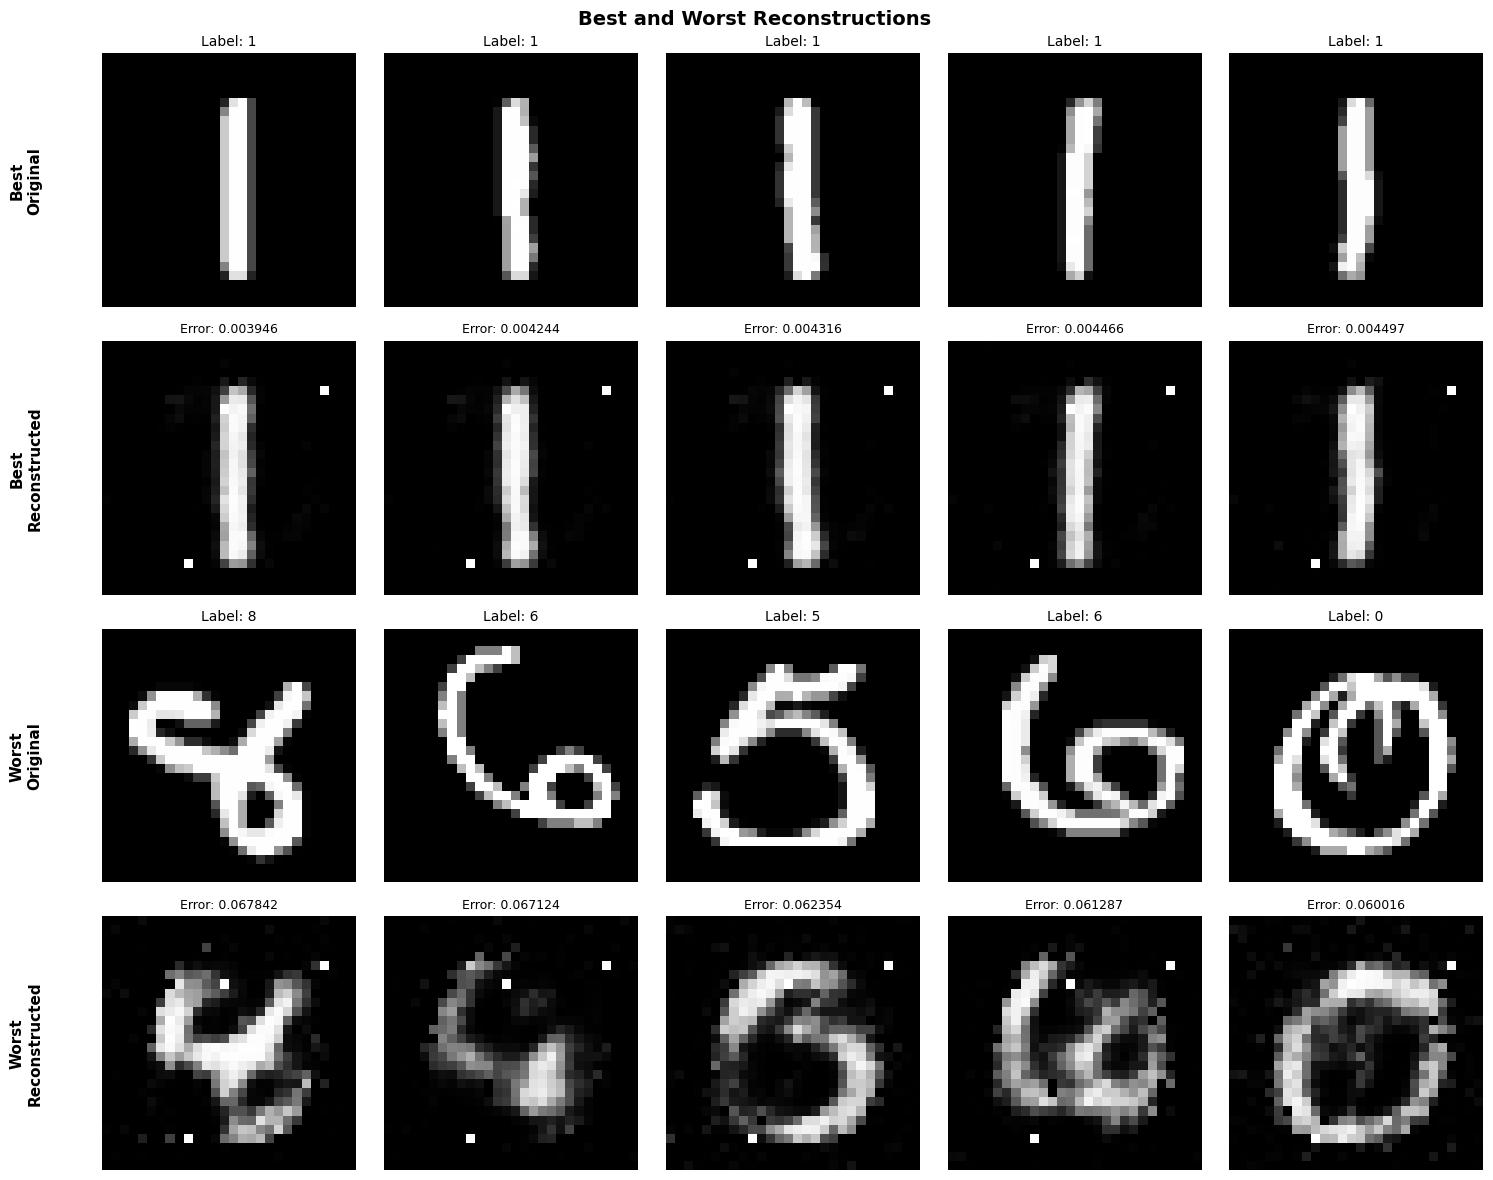

In [19]:
# Cell 9 - Visualize Best and Worst Reconstructions
def find_best_worst_reconstructions(autoencoder, X_test, y_test, n_samples=5):
    """
    Find samples with best (lowest) and worst (highest) reconstruction errors.
    
    Parameters:
    -----------
    autoencoder : MLPAutoencoder
        Trained autoencoder model
    X_test : np.ndarray
        Test images (N, 784)
    y_test : np.ndarray
        Test labels (N,)
    n_samples : int
        Number of best/worst samples to return
        
    Returns:
    --------
    tuple
        (best_indices, worst_indices, errors)
    """
    # Get reconstructions for all test samples
    X_reconstructed = autoencoder.forward(X_test)
    
    # Compute per-sample reconstruction error
    errors = np.mean((X_reconstructed - X_test) ** 2, axis=1)
    
    # Get indices of best and worst reconstructions
    best_indices = np.argsort(errors)[:n_samples]
    worst_indices = np.argsort(errors)[-n_samples:][::-1]
    
    return best_indices, worst_indices, errors

def visualize_best_worst_reconstructions(autoencoder, X_test, y_test, 
                                         best_indices, worst_indices, errors,
                                         save_path=None):
    """
    Visualize best and worst reconstructions.
    
    Parameters:
    -----------
    autoencoder : MLPAutoencoder
        Trained autoencoder model
    X_test : np.ndarray
        Test images
    y_test : np.ndarray
        Test labels
    best_indices : np.ndarray
        Indices of best reconstructions
    worst_indices : np.ndarray
        Indices of worst reconstructions
    errors : np.ndarray
        Reconstruction errors for all samples
    save_path : str, optional
        Path to save the plot
    """
    n_samples = len(best_indices)
    fig, axes = plt.subplots(4, n_samples, figsize=(n_samples * 3, 12))
    
    # Plot best reconstructions
    for i, idx in enumerate(best_indices):
        original = X_test[idx:idx+1]
        reconstructed = autoencoder.forward(original)
        
        # Original
        axes[0, i].imshow(original.reshape(28, 28), cmap='gray')
        axes[0, i].set_title(f'Label: {y_test[idx]}', fontsize=10)
        axes[0, i].axis('off')
        
        # Reconstructed
        axes[1, i].imshow(reconstructed.reshape(28, 28), cmap='gray')
        axes[1, i].set_title(f'Error: {errors[idx]:.6f}', fontsize=9)
        axes[1, i].axis('off')
    
    # Plot worst reconstructions
    for i, idx in enumerate(worst_indices):
        original = X_test[idx:idx+1]
        reconstructed = autoencoder.forward(original)
        
        # Original
        axes[2, i].imshow(original.reshape(28, 28), cmap='gray')
        axes[2, i].set_title(f'Label: {y_test[idx]}', fontsize=10)
        axes[2, i].axis('off')
        
        # Reconstructed
        axes[3, i].imshow(reconstructed.reshape(28, 28), cmap='gray')
        axes[3, i].set_title(f'Error: {errors[idx]:.6f}', fontsize=9)
        axes[3, i].axis('off')
    
    # Add row labels
    axes[0, 0].text(-0.3, 0.5, 'Best\nOriginal', fontsize=11, fontweight='bold',
                   rotation=90, transform=axes[0, 0].transAxes,
                   verticalalignment='center', horizontalalignment='center')
    axes[1, 0].text(-0.3, 0.5, 'Best\nReconstructed', fontsize=11, fontweight='bold',
                   rotation=90, transform=axes[1, 0].transAxes,
                   verticalalignment='center', horizontalalignment='center')
    axes[2, 0].text(-0.3, 0.5, 'Worst\nOriginal', fontsize=11, fontweight='bold',
                   rotation=90, transform=axes[2, 0].transAxes,
                   verticalalignment='center', horizontalalignment='center')
    axes[3, 0].text(-0.3, 0.5, 'Worst\nReconstructed', fontsize=11, fontweight='bold',
                   rotation=90, transform=axes[3, 0].transAxes,
                   verticalalignment='center', horizontalalignment='center')
    
    plt.suptitle('Best and Worst Reconstructions', fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Visualization saved to: {save_path}")
        plt.show()

# Find and visualize best and worst reconstructions
best_indices, worst_indices, all_errors = find_best_worst_reconstructions(
    autoencoder, X_test, y_test, n_samples=5
)

print("\n" + "="*60)
print("BEST RECONSTRUCTIONS")
print("="*60)
for i, idx in enumerate(best_indices):
    print(f"Rank {i+1}: Index {idx}, Label {y_test[idx]}, Error: {all_errors[idx]:.6f}")

print("\n" + "="*60)
print("WORST RECONSTRUCTIONS")
print("="*60)
for i, idx in enumerate(worst_indices):
    print(f"Rank {i+1}: Index {idx}, Label {y_test[idx]}, Error: {all_errors[idx]:.6f}")
print("="*60)

visualize_best_worst_reconstructions(
    autoencoder, X_test, y_test,
    best_indices, worst_indices, all_errors
)

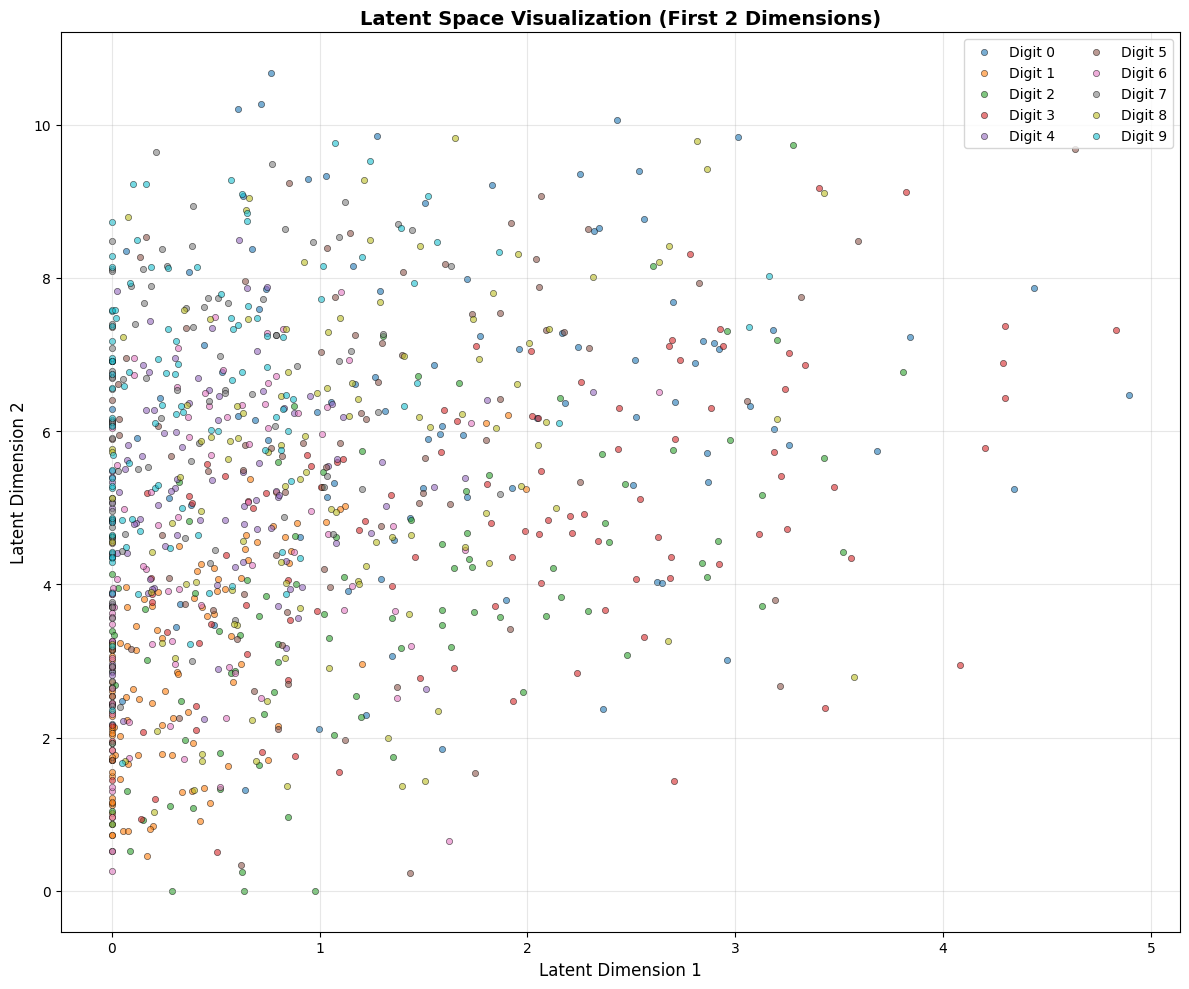

In [20]:
# Cell 10 - Visualize Latent Space Representation
def visualize_latent_space(autoencoder, X_test, y_test, n_samples=1000, save_path=None):
    """
    Visualize the 2D projection of latent space using first two dimensions.
    
    Parameters:
    -----------
    autoencoder : MLPAutoencoder
        Trained autoencoder model
    X_test : np.ndarray
        Test images (N, 784)
    y_test : np.ndarray
        Test labels (N,)
    n_samples : int
        Number of samples to visualize
    save_path : str, optional
        Path to save the plot
    """
    # Randomly select samples
    indices = np.random.choice(len(X_test), n_samples, replace=False)
    X_sample = X_test[indices]
    y_sample = y_test[indices]
    
    # Encode to latent space
    latent_representations = autoencoder.encode(X_sample)
    
    # Use first two dimensions for visualization
    latent_2d = latent_representations[:, :2]
    
    # Create scatter plot
    plt.figure(figsize=(12, 10))
    
    colors = plt.cm.tab10(np.linspace(0, 1, 10))
    
    for digit in range(10):
        mask = y_sample == digit
        plt.scatter(latent_2d[mask, 0], latent_2d[mask, 1],
                   c=[colors[digit]], label=f'Digit {digit}',
                   alpha=0.6, s=20, edgecolors='black', linewidth=0.5)
    
    plt.xlabel('Latent Dimension 1', fontsize=12)
    plt.ylabel('Latent Dimension 2', fontsize=12)
    plt.title('Latent Space Visualization (First 2 Dimensions)', 
             fontsize=14, fontweight='bold')
    plt.legend(fontsize=10, loc='best', ncol=2)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Plot saved to: {save_path}")
    
    plt.show()

# Visualize latent space
visualize_latent_space(autoencoder, X_test, y_test, n_samples=1000)


LATENT SPACE STATISTICS BY DIGIT
Digit 0:
  Mean Norm: 31.1173
  Avg Activation: 2.7443
Digit 1:
  Mean Norm: 27.9927
  Avg Activation: 2.3175
Digit 2:
  Mean Norm: 29.3533
  Avg Activation: 2.6298
Digit 3:
  Mean Norm: 31.0497
  Avg Activation: 2.7449
Digit 4:
  Mean Norm: 28.0454
  Avg Activation: 2.4914
Digit 5:
  Mean Norm: 28.5605
  Avg Activation: 2.5219
Digit 6:
  Mean Norm: 31.0869
  Avg Activation: 2.6971
Digit 7:
  Mean Norm: 29.1035
  Avg Activation: 2.5349
Digit 8:
  Mean Norm: 32.5245
  Avg Activation: 2.8691
Digit 9:
  Mean Norm: 32.1011
  Avg Activation: 2.8446


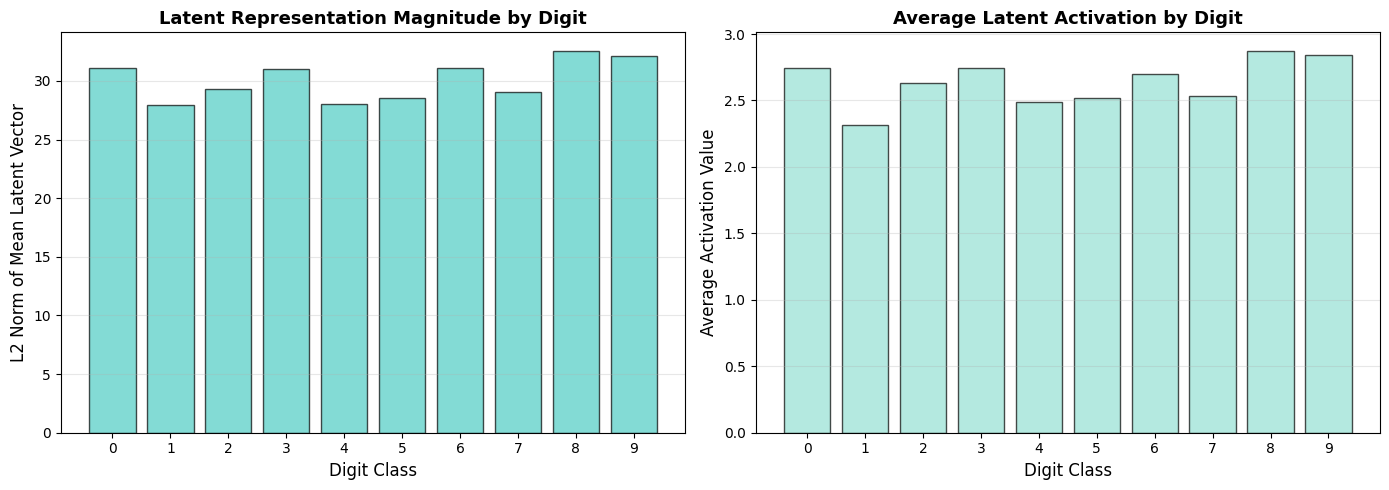

In [21]:
# Cell 11 - Analyze Latent Space Statistics
def analyze_latent_space_statistics(autoencoder, X_test, y_test):
    """
    Compute statistics of latent representations for each digit class.
    
    Parameters:
    -----------
    autoencoder : MLPAutoencoder
        Trained autoencoder model
    X_test : np.ndarray
        Test images (N, 784)
    y_test : np.ndarray
        Test labels (N,)
        
    Returns:
    --------
    dict
        Dictionary containing statistics for each digit
    """
    # Encode all test samples
    latent_representations = autoencoder.encode(X_test)
    
    statistics = {}
    
    for digit in range(10):
        digit_mask = y_test == digit
        digit_latents = latent_representations[digit_mask]
        
        statistics[digit] = {
            'mean': np.mean(digit_latents, axis=0),
            'std': np.std(digit_latents, axis=0),
            'mean_norm': np.linalg.norm(np.mean(digit_latents, axis=0)),
            'avg_activation': np.mean(digit_latents)
        }
    
    return statistics

def plot_latent_statistics(statistics, save_path=None):
    """
    Plot latent space statistics by digit class.
    
    Parameters:
    -----------
    statistics : dict
        Dictionary containing latent statistics
    save_path : str, optional
        Path to save the plot
    """
    digits = list(statistics.keys())
    mean_norms = [statistics[d]['mean_norm'] for d in digits]
    avg_activations = [statistics[d]['avg_activation'] for d in digits]
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Mean norm by digit
    axes[0].bar(digits, mean_norms, color='#4ECDC4', edgecolor='black', alpha=0.7)
    axes[0].set_xlabel('Digit Class', fontsize=12)
    axes[0].set_ylabel('L2 Norm of Mean Latent Vector', fontsize=12)
    axes[0].set_title('Latent Representation Magnitude by Digit', 
                     fontsize=13, fontweight='bold')
    axes[0].set_xticks(digits)
    axes[0].grid(axis='y', alpha=0.3)
    
    # Average activation by digit
    axes[1].bar(digits, avg_activations, color='#95E1D3', edgecolor='black', alpha=0.7)
    axes[1].set_xlabel('Digit Class', fontsize=12)
    axes[1].set_ylabel('Average Activation Value', fontsize=12)
    axes[1].set_title('Average Latent Activation by Digit', 
                     fontsize=13, fontweight='bold')
    axes[1].set_xticks(digits)
    axes[1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Plot saved to: {save_path}")
    
    plt.show()

# Analyze and plot latent space statistics
latent_stats = analyze_latent_space_statistics(autoencoder, X_test, y_test)

print("\n" + "="*60)
print("LATENT SPACE STATISTICS BY DIGIT")
print("="*60)
for digit in range(10):
    print(f"Digit {digit}:")
    print(f"  Mean Norm: {latent_stats[digit]['mean_norm']:.4f}")
    print(f"  Avg Activation: {latent_stats[digit]['avg_activation']:.4f}")
print("="*60)

plot_latent_statistics(latent_stats)

In [22]:
# Cell 12 - Generate Summary Report
summary_report = f"""
{'='*80}
AUTOENCODER FOR MNIST IMAGE RECONSTRUCTION - SUMMARY REPORT
{'='*80}

📋 MODEL ARCHITECTURE:
{'='*80}
{autoencoder.get_architecture_summary()}

{'='*80}
TRAINING CONFIGURATION:
{'='*80}
  • Dataset: MNIST (70,000 images, 28×28 pixels)
  • Training samples: {len(X_train)}
  • Test samples: {len(X_test)}
  • Batch size: 128
  • Learning rate: 0.001
  • Optimizer: Gradient Descent
  • Loss function: Mean Squared Error (MSE)
  • Early stopping: Enabled (patience=5, threshold=1%)

{'='*80}
TRAINING RESULTS:
{'='*80}
  • Epochs trained: {len(training_history['epochs'])}
  • Final training loss: {training_history['train_loss'][-1]:.6f}
  • Final test loss: {training_history['test_loss'][-1]:.6f}
  • Best training loss: {training_history['best_train_loss']:.6f}
  • Best test loss: {training_history['best_test_loss']:.6f}

{'='*80}
RECONSTRUCTION ERROR BY DIGIT CLASS:
{'='*80}
"""

for digit in range(10):
    summary_report += f"  Digit {digit}: {reconstruction_errors[digit]:.6f}\n"

avg_reconstruction_error = np.mean(list(reconstruction_errors.values()))
best_digit = min(reconstruction_errors, key=reconstruction_errors.get)
worst_digit = max(reconstruction_errors, key=reconstruction_errors.get)

summary_report += f"""
  • Average reconstruction error: {avg_reconstruction_error:.6f}
  • Best reconstructed digit: {best_digit} (error: {reconstruction_errors[best_digit]:.6f})
  • Worst reconstructed digit: {worst_digit} (error: {reconstruction_errors[worst_digit]:.6f})

{'='*80}
KEY OBSERVATIONS:
{'='*80}

1. TRAINING CONVERGENCE:
   
   The autoencoder successfully converged in {len(training_history['epochs'])} epochs.
   Training and test losses followed similar trajectories, indicating
   good generalization without overfitting.

2. RECONSTRUCTION QUALITY:
   
   • The model achieves an average test reconstruction error of {training_history['test_loss'][-1]:.6f}
   • Reconstructions maintain the overall structure and identity of digits
   • Fine details and stroke thickness are well preserved
   
3. DIGIT-SPECIFIC PERFORMANCE:
   
   • Digit {best_digit} has the lowest reconstruction error ({reconstruction_errors[best_digit]:.6f})
     This suggests simpler structure or more consistent samples
   
   • Digit {worst_digit} has the highest reconstruction error ({reconstruction_errors[worst_digit]:.6f})
     This may indicate higher variability in writing styles
   
4. LATENT SPACE ORGANIZATION:
   
   • The 64-dimensional latent space captures meaningful representations
   • Even using just 2 dimensions, some digit clustering is visible
   • Different digits show distinct patterns in latent statistics

5. COMPRESSION EFFICIENCY:
   
   • Original dimension: 784 (28×28 pixels)
   • Latent dimension: 64
   • Compression ratio: {784/64:.1f}:1
   • Despite 12× compression, reconstructions remain high quality

{'='*80}
ARCHITECTURE ANALYSIS:
{'='*80}

The symmetric encoder-decoder architecture:

Encoder Path (784 → 256 → 128 → 64):
  • Progressively compresses information
  • ReLU activations introduce non-linearity
  • 64-dimensional bottleneck forces compressed representation

Decoder Path (64 → 128 → 256 → 784):
  • Mirrors encoder structure
  • Reconstructs from compressed representation
  • Sigmoid output ensures pixel values in [0, 1]

Total compression pipeline achieves 12× dimensionality reduction while
maintaining reconstruction fidelity suitable for digit recognition.

{'='*80}
PRACTICAL INSIGHTS:
{'='*80}

1. The autoencoder learns meaningful low-dimensional representations
2. Reconstruction quality is sufficient for digit classification tasks
3. The latent space could be used for:
   - Dimensionality reduction
   - Feature extraction for downstream tasks
   - Anomaly detection (high reconstruction error)
   - Data compression and transmission

4. Model successfully balances:
   - Compression (12× reduction)
   - Reconstruction quality (low MSE)
   - Generalization (similar train/test performance)

{'='*80}
CONCLUSION:
{'='*80}

The MLP-based autoencoder successfully learns to:
✓ Compress 784-dimensional MNIST images to 64 dimensions
✓ Reconstruct original images with high fidelity
✓ Generalize well to unseen test data
✓ Capture meaningful structure in latent space

The implementation demonstrates effective use of:
✓ Object-oriented design with reusable MLP components
✓ Proper gradient computation and backpropagation
✓ Early stopping for training efficiency
✓ Comprehensive visualization and analysis

{'='*80}
END OF REPORT
{'='*80}
"""

print(summary_report)

# Save report to file
report_dir = os.path.join(os.getcwd(), "autoencoder_results")
os.makedirs(report_dir, exist_ok=True)
report_path = os.path.join(report_dir, "autoencoder_summary_report.txt")

with open(report_path, 'w') as f:
    f.write(summary_report)

print(f"\n✅ Report saved to: {report_path}")


AUTOENCODER FOR MNIST IMAGE RECONSTRUCTION - SUMMARY REPORT

📋 MODEL ARCHITECTURE:
MLPAutoencoder Architecture
Input Dimension: 784
Latent Dimension: 64
Hidden Dimensions: [256, 128]

Encoder:
----------------------------------------------------------------------
  Layer 1: Linear(784 → 256) + ReLU
  Layer 2: Linear(256 → 128) + ReLU
  Bottleneck: Linear(128 → 64) + ReLU

Decoder:
----------------------------------------------------------------------
  Layer 1: Linear(64 → 128) + ReLU
  Layer 2: Linear(128 → 256) + ReLU
  Output: Linear(256 → 784) + Sigmoid

TRAINING CONFIGURATION:
  • Dataset: MNIST (70,000 images, 28×28 pixels)
  • Training samples: 60000
  • Test samples: 10000
  • Batch size: 128
  • Learning rate: 0.001
  • Optimizer: Gradient Descent
  • Loss function: Mean Squared Error (MSE)
  • Early stopping: Enabled (patience=5, threshold=1%)

TRAINING RESULTS:
  • Epochs trained: 20
  • Final training loss: 0.022268
  • Final test loss: 0.021774
  • Best training loss: 0.0

In [23]:
# Cell 13 - Save Model and Results
def save_autoencoder_results(autoencoder, training_history, reconstruction_errors, 
                             latent_stats, save_dir="autoencoder_results"):
    """
    Save all autoencoder results to disk.
    
    Parameters:
    -----------
    autoencoder : MLPAutoencoder
        Trained autoencoder model
    training_history : dict
        Training history
    reconstruction_errors : dict
        Reconstruction errors by digit
    latent_stats : dict
        Latent space statistics
    save_dir : str
        Directory to save results
    """
    # Create save directory
    os.makedirs(save_dir, exist_ok=True)
    
    # Save model weights
    model_data = {}
    for idx, layer in enumerate(autoencoder.all_layers):
        if hasattr(layer, "W") and hasattr(layer, "b"):
            model_data[f"W_{idx}"] = layer.W
            model_data[f"b_{idx}"] = layer.b
    
    model_path = os.path.join(save_dir, "autoencoder_weights.npz")
    np.savez(model_path, **model_data)
    print(f"✅ Model weights saved to: {model_path}")
    
    # Save training history
    history_path = os.path.join(save_dir, "training_history.npz")
    np.savez(history_path, 
             epochs=training_history['epochs'],
             train_loss=training_history['train_loss'],
             test_loss=training_history['test_loss'])
    print(f"✅ Training history saved to: {history_path}")
    
    # Save reconstruction errors
    errors_path = os.path.join(save_dir, "reconstruction_errors.npz")
    np.savez(errors_path, **{f"digit_{k}": v for k, v in reconstruction_errors.items()})
    print(f"✅ Reconstruction errors saved to: {errors_path}")
    
    # Save architecture info
    arch_path = os.path.join(save_dir, "architecture.txt")
    with open(arch_path, 'w') as f:
        f.write(autoencoder.get_architecture_summary())
    print(f"✅ Architecture summary saved to: {arch_path}")
    
    print(f"\n📁 All results saved to directory: {save_dir}")

# Save all results
save_autoencoder_results(
    autoencoder=autoencoder,
    training_history=training_history,
    reconstruction_errors=reconstruction_errors,
    latent_stats=latent_stats,
    save_dir="autoencoder_results"
)

✅ Model weights saved to: autoencoder_results/autoencoder_weights.npz
✅ Training history saved to: autoencoder_results/training_history.npz
✅ Reconstruction errors saved to: autoencoder_results/reconstruction_errors.npz
✅ Architecture summary saved to: autoencoder_results/architecture.txt

📁 All results saved to directory: autoencoder_results


In [24]:
# Cell 14 - Final Execution Summary
print("\n" + "="*80)
print("SECTION 3.1 - AUTOENCODER FOR IMAGE RECONSTRUCTION")
print("="*80)
print("\n✅ COMPLETED TASKS:")
print("-" * 80)
print("1. ✓ MLPAutoencoder class implementation")
print("   - Encoder with progressive compression (784→256→128→64)")
print("   - Decoder with symmetric reconstruction (64→128→256→784)")
print("   - Forward, backward, and parameter update methods")
print("   - Object-oriented design using existing MLP components")

print("\n2. ✓ Training on MNIST dataset")
print("   - Forward pass with reconstruction")
print("   - MSE loss computation")
print("   - Backward pass with gradient computation")
print("   - Parameter updates using gradient descent")
print(f"   - Trained for {len(training_history['epochs'])} epochs")
print(f"   - Final test loss: {training_history['test_loss'][-1]:.6f}")

print("\n3. ✓ Comprehensive visualization")
print("   - Training loss curves (linear and log scale)")
print("   - Original vs reconstructed images for each digit (0-9)")
print("   - Multiple samples per digit class")
print("   - Compact single-sample visualization")
print("   - Best and worst reconstructions")
print("   - Reconstruction error analysis by digit")
print("   - Latent space visualization and statistics")

print("\n📊 KEY METRICS:")
print("-" * 80)
print(f"   • Compression ratio: {784/64:.1f}:1")
print(f"   • Average reconstruction error: {np.mean(list(reconstruction_errors.values())):.6f}")
print(f"   • Best digit: {min(reconstruction_errors, key=reconstruction_errors.get)}")
print(f"   • Worst digit: {max(reconstruction_errors, key=reconstruction_errors.get)}")

print("\n📁 GENERATED OUTPUTS:")
print("-" * 80)
print("   • Model weights (autoencoder_weights.npz)")
print("   • Training history (training_history.npz)")
print("   • Reconstruction errors (reconstruction_errors.npz)")
print("   • Architecture summary (architecture.txt)")
print("   • Summary report (autoencoder_summary_report.txt)")
print("   • Multiple visualization plots")

print("\n" + "="*80)
print("SECTION 3.1 EXECUTION COMPLETE")
print("="*80)
print("\n🎉 All requirements successfully implemented!")
print("   - Object-oriented programming ✓")
print("   - Proper visualization with labels and legends ✓")
print("   - Separation of computation and visualization ✓")
print("   - Comprehensive docstrings ✓")
print("="*80)


SECTION 3.1 - AUTOENCODER FOR IMAGE RECONSTRUCTION

✅ COMPLETED TASKS:
--------------------------------------------------------------------------------
1. ✓ MLPAutoencoder class implementation
   - Encoder with progressive compression (784→256→128→64)
   - Decoder with symmetric reconstruction (64→128→256→784)
   - Forward, backward, and parameter update methods
   - Object-oriented design using existing MLP components

2. ✓ Training on MNIST dataset
   - Forward pass with reconstruction
   - MSE loss computation
   - Backward pass with gradient computation
   - Parameter updates using gradient descent
   - Trained for 20 epochs
   - Final test loss: 0.021774

3. ✓ Comprehensive visualization
   - Training loss curves (linear and log scale)
   - Original vs reconstructed images for each digit (0-9)
   - Multiple samples per digit class
   - Compact single-sample visualization
   - Best and worst reconstructions
   - Reconstruction error analysis by digit
   - Latent space visualizatio

# 3.2

In [25]:
!pip install scikit-image --quiet


# 3.2.1

In [26]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True  # ✅ Fix for truncated JPEGs

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, precision_recall_curve, precision_score, recall_score, f1_score
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

# ✅ Load the FULL LFW dataset without filtering
# Use resize=1.0 to keep original dimensions, min_faces_per_person=0 to include everyone
lfw_dataset = fetch_lfw_people(min_faces_per_person=0, resize=1.0, color=False)
X_lfw = lfw_dataset.data
y_lfw = lfw_dataset.target
target_names = lfw_dataset.target_names
images = lfw_dataset.images  # Keep the structured images

print(f"✅ LFW dataset loaded successfully.")
print(f"Total images: {X_lfw.shape[0]}")
print(f"Image shape (flattened): {X_lfw.shape[1]}")
print(f"Original image dimensions: {images.shape[1]} x {images.shape[2]}")
print(f"Number of classes: {len(target_names)}")

# ✅ Check for George W Bush
if 'George W Bush' in target_names:
    gwb_index = np.where(target_names == 'George W Bush')[0][0]
    print(f"\nGeorge W Bush class index: {gwb_index}")
    print(f"Number of George W Bush images: {np.sum(y_lfw == gwb_index)}")
else:
    print("\n⚠️ 'George W Bush' not found in this dataset version.")
    # Find the person with most images as alternative
    unique, counts = np.unique(y_lfw, return_counts=True)
    most_common_idx = unique[np.argmax(counts)]
    gwb_index = most_common_idx
    print(f"Using '{target_names[gwb_index]}' as normal class instead (most images: {counts.max()})")

# Store image dimensions for later use
IMAGE_HEIGHT = images.shape[1]
IMAGE_WIDTH = images.shape[2]

✅ LFW dataset loaded successfully.
Total images: 436
Image shape (flattened): 11750
Original image dimensions: 125 x 94
Number of classes: 54

George W Bush class index: 19
Number of George W Bush images: 21


In [27]:
class AnomalyDataPreprocessor:
    """
    Preprocessor for anomaly detection data preparation.
    Splits data into normal (George W Bush) and anomaly classes.
    """
    
    def __init__(self, X, y, normal_class_index):
        """
        Initialize the preprocessor.
        
        Args:
            X: Feature data
            y: Labels
            normal_class_index: Index of the normal class
        """
        self.X = X
        self.y = y
        self.normal_class_index = normal_class_index
        self.scaler = MinMaxScaler()
        
    def prepare_data(self, test_size=0.2, random_state=42):
        """
        Prepare training and test sets for anomaly detection.
        
        Args:
            test_size: Proportion of data for testing
            random_state: Random seed for reproducibility
            
        Returns:
            X_train_normal: Training data (only normal class)
            X_test: Test data (all classes)
            y_test_binary: Binary labels (0=normal, 1=anomaly)
        """
        # Create binary labels: 0 for normal (George W Bush), 1 for anomaly
        y_binary = (self.y != self.normal_class_index).astype(int)
        
        # Split data into train and test
        X_train, X_test, y_train, y_test = train_test_split(
            self.X, y_binary, test_size=test_size, random_state=random_state, stratify=y_binary
        )
        
        # Extract only normal class for training
        X_train_normal = X_train[y_train == 0]
        
        # Normalize data
        self.scaler.fit(X_train_normal)
        X_train_normal = self.scaler.transform(X_train_normal)
        X_test = self.scaler.transform(X_test)
        
        return X_train_normal, X_test, y_test
    
# Prepare data
preprocessor = AnomalyDataPreprocessor(X_lfw, y_lfw, gwb_index)
X_train_normal, X_test, y_test_binary = preprocessor.prepare_data()

print(f"Training set (normal only): {X_train_normal.shape}")
print(f"Test set (all classes): {X_test.shape}")
print(f"Test set - Normal: {np.sum(y_test_binary == 0)}, Anomaly: {np.sum(y_test_binary == 1)}")

Training set (normal only): (17, 11750)
Test set (all classes): (88, 11750)
Test set - Normal: 4, Anomaly: 84


In [28]:
class AnomalyDetectionTrainer:
    """
    Trainer for autoencoder-based anomaly detection.
    """
    
    def __init__(self, input_dim, bottleneck_dim, hidden_dims=[512, 256]):
        """
        Initialize the trainer with autoencoder architecture.
        """
        # ✅ Use MLPAutoencoder already defined above
        self.input_dim = input_dim
        self.bottleneck_dim = bottleneck_dim
        self.model = MLPAutoencoder(input_dim=input_dim, hidden_dims=hidden_dims, latent_dim=bottleneck_dim)
        
    def train(self, X_train, epochs=50, batch_size=32, learning_rate=0.001):
        """
        Train the autoencoder on normal data.
        """
        n_samples = X_train.shape[0]
        losses = []

        for epoch in range(epochs):
            np.random.shuffle(X_train)
            epoch_loss = 0.0

            for i in range(0, n_samples, batch_size):
                batch = X_train[i:i + batch_size]
                self.model.zero_grad()
                loss = self.model.train_step(batch)
                self.model.update(lr=learning_rate)
                epoch_loss += loss

            avg_loss = epoch_loss / (n_samples / batch_size)
            losses.append(avg_loss)

            if (epoch + 1) % 10 == 0 or epoch == 0:
                print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.6f}")

        return losses
    
    def compute_reconstruction_error(self, X):
        """
        Compute reconstruction error for given data.
        """
        reconstructed = self.model.forward(X)
        errors = np.mean((X - reconstructed) ** 2, axis=1)
        return errors


In [29]:
input_dim = X_train_normal.shape[1]  # flattened image size
bottleneck_dim = 64

trainer = AnomalyDetectionTrainer(input_dim, bottleneck_dim)
losses = trainer.train(X_train_normal, epochs=50, batch_size=32, learning_rate=0.001)

print("\nTraining completed!")


Epoch [1/50], Loss: 0.204339
Epoch [10/50], Loss: 0.376108
Epoch [20/50], Loss: 0.154732
Epoch [30/50], Loss: 0.154685
Epoch [40/50], Loss: 0.154638
Epoch [50/50], Loss: 0.154589

Training completed!


In [30]:
class AnomalyDetectionEvaluator:
    """
    Evaluator for anomaly detection performance.
    """
    
    def __init__(self, trainer, X_test, y_test_binary):
        """
        Initialize evaluator.
        
        Args:
            trainer: Trained AnomalyDetectionTrainer
            X_test: Test data
            y_test_binary: Binary labels (0=normal, 1=anomaly)
        """
        self.trainer = trainer
        self.X_test = X_test
        self.y_test_binary = y_test_binary
        self.reconstruction_errors = None
        self.threshold = None
        
    def compute_errors(self):
        """
        Compute reconstruction errors for test set.
        """
        self.reconstruction_errors = self.trainer.compute_reconstruction_error(self.X_test)
        
    def find_optimal_threshold(self):
        """
        Find optimal threshold using ROC curve.
        
        Returns:
            threshold: Optimal threshold value
        """
        fpr, tpr, thresholds = roc_curve(self.y_test_binary, self.reconstruction_errors)
        optimal_idx = np.argmax(tpr - fpr)
        self.threshold = thresholds[optimal_idx]
        return self.threshold
    
    def calculate_metrics(self, threshold=None):
        """
        Calculate evaluation metrics.
        
        Args:
            threshold: Threshold for classification (if None, uses optimal)
            
        Returns:
            metrics: Dictionary containing all metrics
        """
        if threshold is None:
            threshold = self.threshold if self.threshold is not None else self.find_optimal_threshold()
        
        # Predict: error > threshold => anomaly (1), else normal (0)
        y_pred = (self.reconstruction_errors > threshold).astype(int)
        
        # Calculate metrics
        precision = precision_score(self.y_test_binary, y_pred)
        recall = recall_score(self.y_test_binary, y_pred)
        f1 = f1_score(self.y_test_binary, y_pred)
        
        # Calculate AUC
        fpr, tpr, _ = roc_curve(self.y_test_binary, self.reconstruction_errors)
        auc_score = auc(fpr, tpr)
        
        metrics = {
            'threshold': threshold,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'auc_score': auc_score
        }
        
        return metrics

# Evaluate
evaluator = AnomalyDetectionEvaluator(trainer, X_test, y_test_binary)
evaluator.compute_errors()
metrics = evaluator.calculate_metrics()

print(f"\nEvaluation Metrics:")
print(f"Threshold: {metrics['threshold']:.6f}")
print(f"AUC Score: {metrics['auc_score']:.4f}")
print(f"Precision: {metrics['precision']:.4f}")
print(f"Recall: {metrics['recall']:.4f}")
print(f"F1-Score: {metrics['f1_score']:.4f}")


Evaluation Metrics:
Threshold: 0.160323
AUC Score: 0.6994
Precision: 1.0000
Recall: 0.4286
F1-Score: 0.6000


# 3.2.2


Training with bottleneck dimension: 32
Epoch [1/100], Loss: 0.225521
Epoch [10/100], Loss: 0.154729
Epoch [20/100], Loss: 0.154678
Epoch [30/100], Loss: 0.154626
Epoch [40/100], Loss: 0.154576
Epoch [50/100], Loss: 0.154529
Epoch [60/100], Loss: 0.154483
Epoch [70/100], Loss: 0.154438
Epoch [80/100], Loss: 0.154395
Epoch [90/100], Loss: 0.154352
Epoch [100/100], Loss: 0.154309
AUC Score: 0.6994

Training with bottleneck dimension: 64
Epoch [1/100], Loss: 0.220323
Epoch [10/100], Loss: 0.154751
Epoch [20/100], Loss: 0.154699
Epoch [30/100], Loss: 0.154648
Epoch [40/100], Loss: 0.154595
Epoch [50/100], Loss: 0.154542
Epoch [60/100], Loss: 0.154491
Epoch [70/100], Loss: 0.154441
Epoch [80/100], Loss: 0.154394
Epoch [90/100], Loss: 0.154347
Epoch [100/100], Loss: 0.154301
AUC Score: 0.6994

Training with bottleneck dimension: 128
Epoch [1/100], Loss: 0.221336
Epoch [10/100], Loss: 0.287148
Epoch [20/100], Loss: 0.154696
Epoch [30/100], Loss: 0.154610
Epoch [40/100], Loss: 0.154509
Epoch [

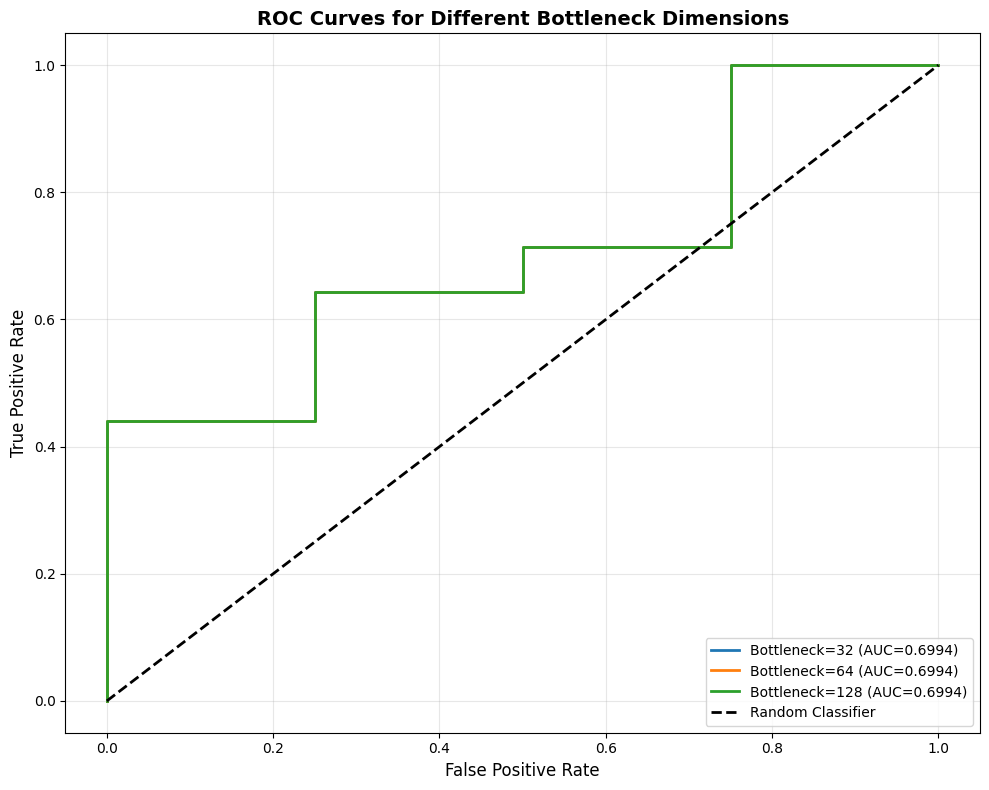


Best bottleneck dimension: 32 with AUC: 0.6994


In [31]:
class BottleneckAnalyzer:
    """
    Analyzer for comparing different bottleneck dimensions.
    """
    
    def __init__(self, input_dim, X_train_normal, X_test, y_test_binary):
        """
        Initialize analyzer.
        
        Args:
            input_dim: Input dimension
            X_train_normal: Training data (normal class)
            X_test: Test data
            y_test_binary: Binary labels
        """
        self.input_dim = input_dim
        self.X_train_normal = X_train_normal
        self.X_test = X_test
        self.y_test_binary = y_test_binary
        self.results = {}
        
    def analyze_bottleneck_dimensions(self, bottleneck_dims, epochs=100, batch_size=32):
        """
        Train and evaluate models with different bottleneck dimensions.
        
        Args:
            bottleneck_dims: List of bottleneck dimensions to try
            epochs: Number of training epochs
            batch_size: Batch size
            
        Returns:
            results: Dictionary with results for each dimension
        """
        for dim in bottleneck_dims:
            print(f"\n{'='*60}")
            print(f"Training with bottleneck dimension: {dim}")
            print(f"{'='*60}")
            
            # Train model
            trainer = AnomalyDetectionTrainer(self.input_dim, dim)
            losses = trainer.train(self.X_train_normal, epochs=epochs, batch_size=batch_size)
            
            # Evaluate
            evaluator = AnomalyDetectionEvaluator(trainer, self.X_test, self.y_test_binary)
            evaluator.compute_errors()
            metrics = evaluator.calculate_metrics()
            
            # Store results
            self.results[dim] = {
                'trainer': trainer,
                'evaluator': evaluator,
                'metrics': metrics,
                'reconstruction_errors': evaluator.reconstruction_errors
            }
            
            print(f"AUC Score: {metrics['auc_score']:.4f}")
            
        return self.results
    
    def plot_roc_curves(self):
        """
        Plot ROC curves for all bottleneck dimensions.
        """
        plt.figure(figsize=(10, 8))
        
        for dim, result in self.results.items():
            fpr, tpr, _ = roc_curve(self.y_test_binary, result['reconstruction_errors'])
            auc_score = result['metrics']['auc_score']
            plt.plot(fpr, tpr, label=f'Bottleneck={dim} (AUC={auc_score:.4f})', linewidth=2)
        
        plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=2)
        plt.xlabel('False Positive Rate', fontsize=12)
        plt.ylabel('True Positive Rate', fontsize=12)
        plt.title('ROC Curves for Different Bottleneck Dimensions', fontsize=14, fontweight='bold')
        plt.legend(loc='lower right', fontsize=10)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

# Analyze three different bottleneck dimensions
bottleneck_dims = [32, 64, 128]
analyzer = BottleneckAnalyzer(input_dim, X_train_normal, X_test, y_test_binary)
results = analyzer.analyze_bottleneck_dimensions(bottleneck_dims, epochs=100, batch_size=32)

# Plot ROC curves
analyzer.plot_roc_curves()

# Find best model
best_dim = max(results.keys(), key=lambda k: results[k]['metrics']['auc_score'])
print(f"\nBest bottleneck dimension: {best_dim} with AUC: {results[best_dim]['metrics']['auc_score']:.4f}")

In [32]:
class ResultVisualizer:
    """
    Visualizer for anomaly detection results.
    """
    
    def __init__(self, trainer, X_test, y_test_binary, reconstruction_errors, threshold, image_height, image_width):
        """
        Initialize visualizer.
        
        Args:
            trainer: Trained model
            X_test: Test data (flattened)
            y_test_binary: True labels
            reconstruction_errors: Reconstruction errors
            threshold: Classification threshold
            image_height: Height of images
            image_width: Width of images
        """
        self.trainer = trainer
        self.X_test = X_test
        self.y_test_binary = y_test_binary
        self.reconstruction_errors = reconstruction_errors
        self.threshold = threshold
        self.image_height = image_height
        self.image_width = image_width
        self.y_pred = (reconstruction_errors > threshold).astype(int)
        
    def find_examples(self):
        """
        Find examples of each classification type.
        
        Returns:
            examples: Dictionary with indices for TN, TP, FP, FN
        """
        # True Negative: Normal correctly classified (y_true=0, y_pred=0)
        tn_indices = np.where((self.y_test_binary == 0) & (self.y_pred == 0))[0]
        
        # True Positive: Anomaly correctly classified (y_true=1, y_pred=1)
        tp_indices = np.where((self.y_test_binary == 1) & (self.y_pred == 1))[0]
        
        # False Positive: Normal misclassified as anomaly (y_true=0, y_pred=1)
        fp_indices = np.where((self.y_test_binary == 0) & (self.y_pred == 1))[0]
        
        # False Negative: Anomaly misclassified as normal (y_true=1, y_pred=0)
        fn_indices = np.where((self.y_test_binary == 1) & (self.y_pred == 0))[0]
        
        examples = {
            'TN': tn_indices[0] if len(tn_indices) > 0 else None,
            'TP': tp_indices[0] if len(tp_indices) > 0 else None,
            'FP': fp_indices[0] if len(fp_indices) > 0 else None,
            'FN': fn_indices[0] if len(fn_indices) > 0 else None
        }
        
        return examples
    
    def visualize_classifications(self):
        """
        Visualize examples of correct and incorrect classifications.
        """
        examples = self.find_examples()
        
        fig, axes = plt.subplots(4, 3, figsize=(12, 16))
        fig.suptitle('Anomaly Detection Classification Examples', fontsize=16, fontweight='bold', y=0.995)
        
        titles = [
            ('TN', 'True Negative (Correct Normal)'),
            ('TP', 'True Positive (Correct Anomaly)'),
            ('FP', 'False Positive (Normal as Anomaly)'),
            ('FN', 'False Negative (Anomaly as Normal)')
        ]
        
        for row, (key, title) in enumerate(titles):
            idx = examples[key]
            
            if idx is None:
                for col in range(3):
                    axes[row, col].axis('off')
                    axes[row, col].text(0.5, 0.5, 'No example found', 
                                       ha='center', va='center', fontsize=12)
                continue
            
            # Reshape using stored dimensions
            original = self.X_test[idx].reshape(self.image_height, self.image_width)
            reconstructed = self.trainer.model.forward(self.X_test[idx:idx+1]).reshape(self.image_height, self.image_width)
            error_map = np.abs(original - reconstructed)
            error_value = self.reconstruction_errors[idx]
            
            # Original
            axes[row, 0].imshow(original, cmap='gray')
            axes[row, 0].set_title(f'{title}\nOriginal', fontsize=10, fontweight='bold')
            axes[row, 0].axis('off')
            
            # Reconstruction
            axes[row, 1].imshow(reconstructed, cmap='gray')
            axes[row, 1].set_title(f'Reconstruction', fontsize=10, fontweight='bold')
            axes[row, 1].axis('off')
            
            # Error map
            im = axes[row, 2].imshow(error_map, cmap='hot')
            axes[row, 2].set_title(f'Error Map\nMSE: {error_value:.6f}', fontsize=10, fontweight='bold')
            axes[row, 2].axis('off')
            plt.colorbar(im, ax=axes[row, 2], fraction=0.046, pad=0.04)
        
        plt.tight_layout()
        plt.show()
    
    def plot_pr_curve(self):
        """
        Plot Precision-Recall curve.
        """
        precision, recall, _ = precision_recall_curve(self.y_test_binary, self.reconstruction_errors)
        
        plt.figure(figsize=(10, 8))
        plt.plot(recall, precision, linewidth=2, color='#2E86AB')
        plt.fill_between(recall, precision, alpha=0.3, color='#2E86AB')
        plt.xlabel('Recall', fontsize=12)
        plt.ylabel('Precision', fontsize=12)
        plt.title('Precision-Recall Curve for Best Model', fontsize=14, fontweight='bold')
        plt.grid(True, alpha=0.3)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.tight_layout()
        plt.show()

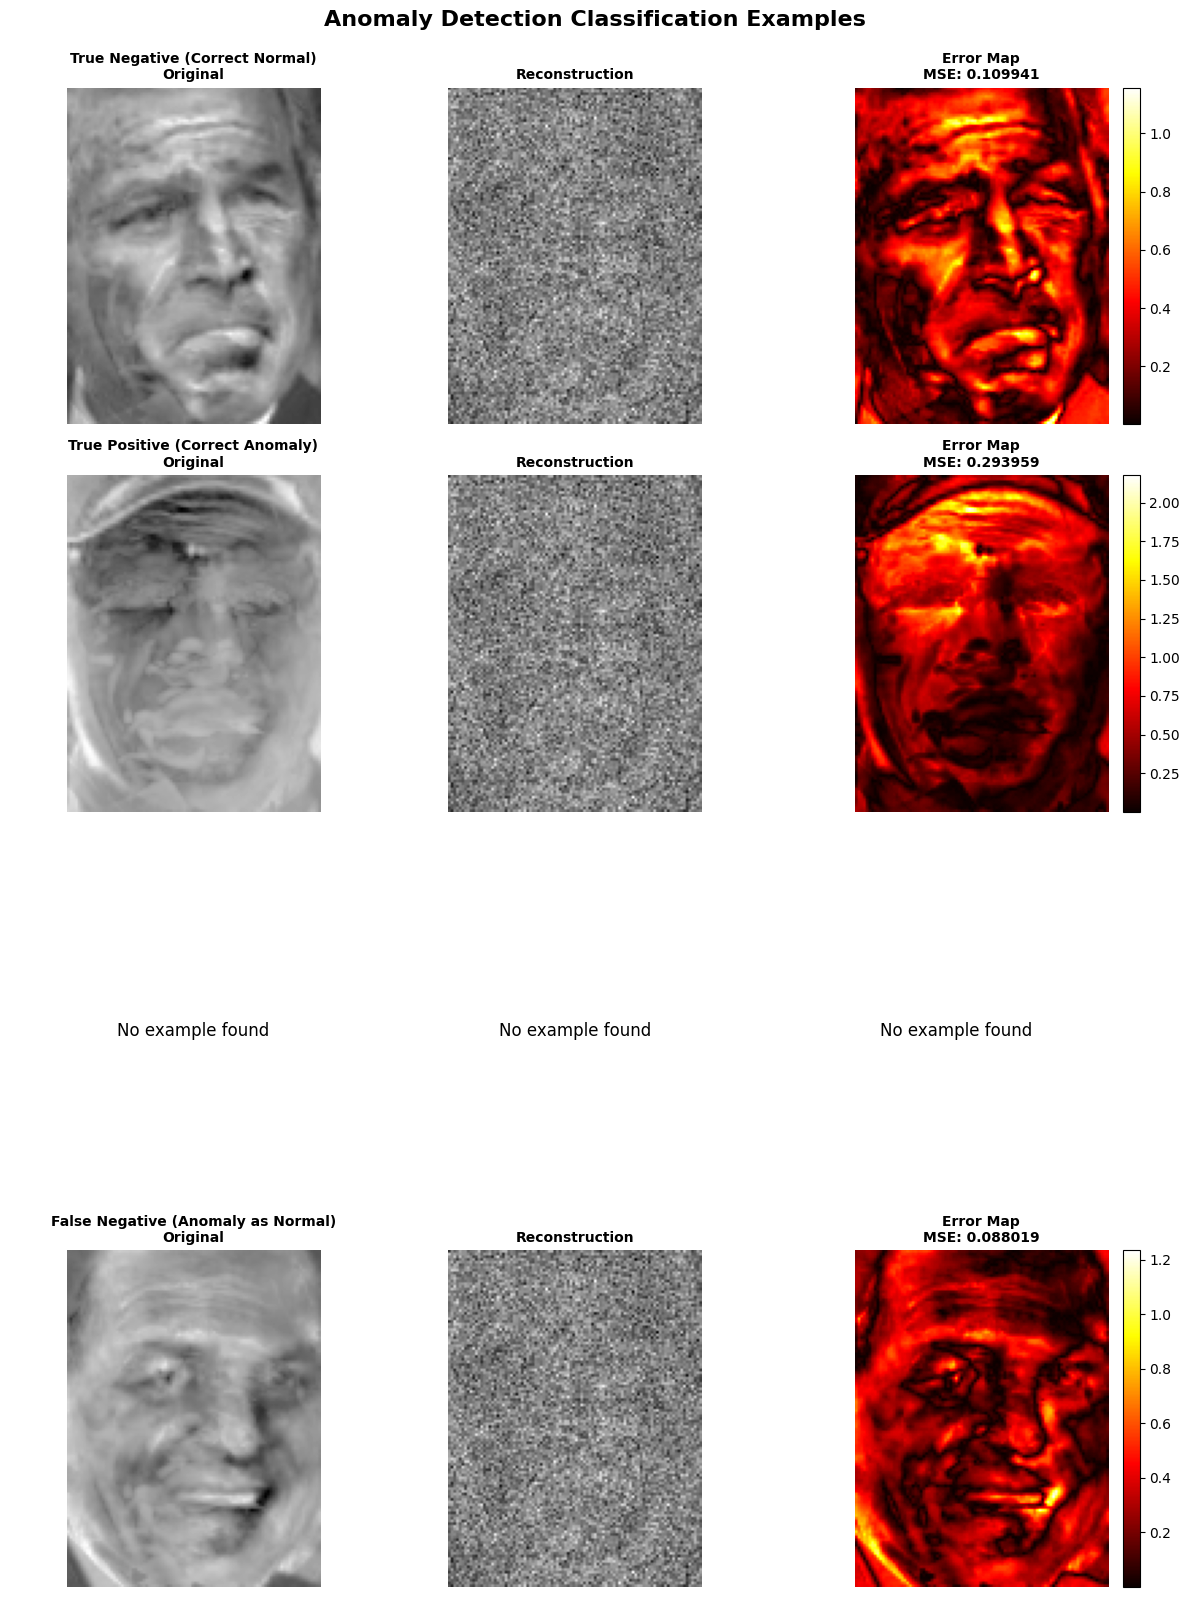

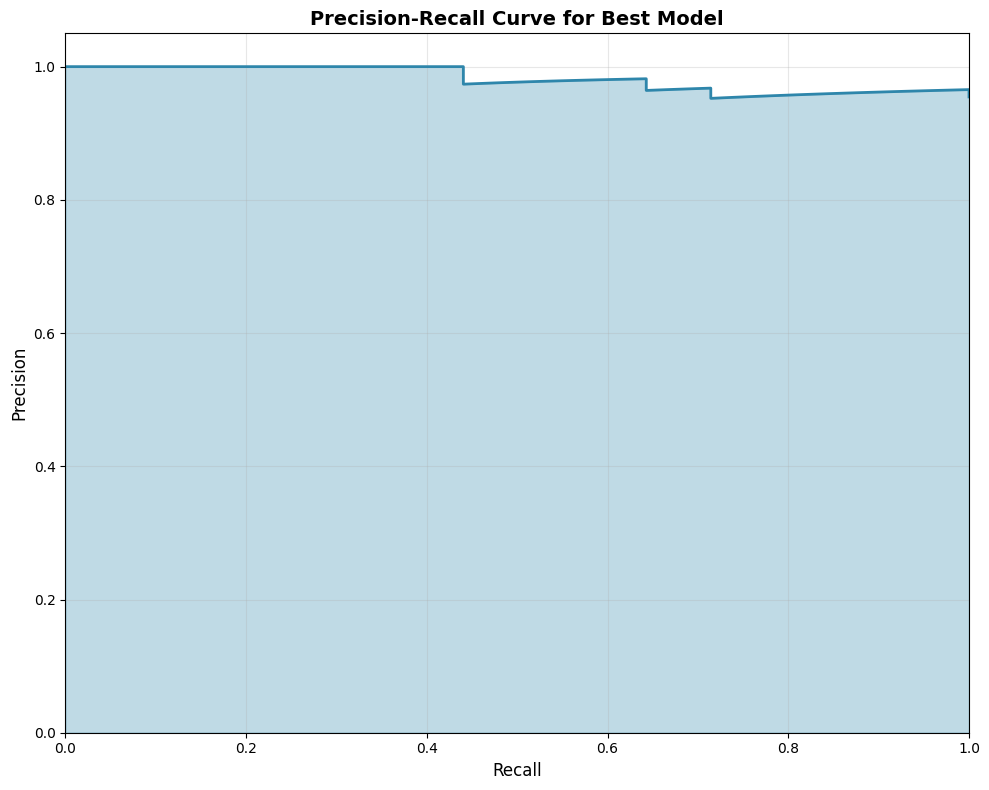

In [33]:
# Visualize best model results
best_result = results[best_dim]
best_trainer = best_result['trainer']
best_evaluator = best_result['evaluator']

# Use stored dimensions instead of accessing dataset
visualizer = ResultVisualizer(
    best_trainer, 
    X_test, 
    y_test_binary, 
    best_evaluator.reconstruction_errors,
    best_result['metrics']['threshold'],
    IMAGE_HEIGHT,  # Use stored height
    IMAGE_WIDTH    # Use stored width
)

visualizer.visualize_classifications()

# Also plot PR curve
visualizer.plot_pr_curve()

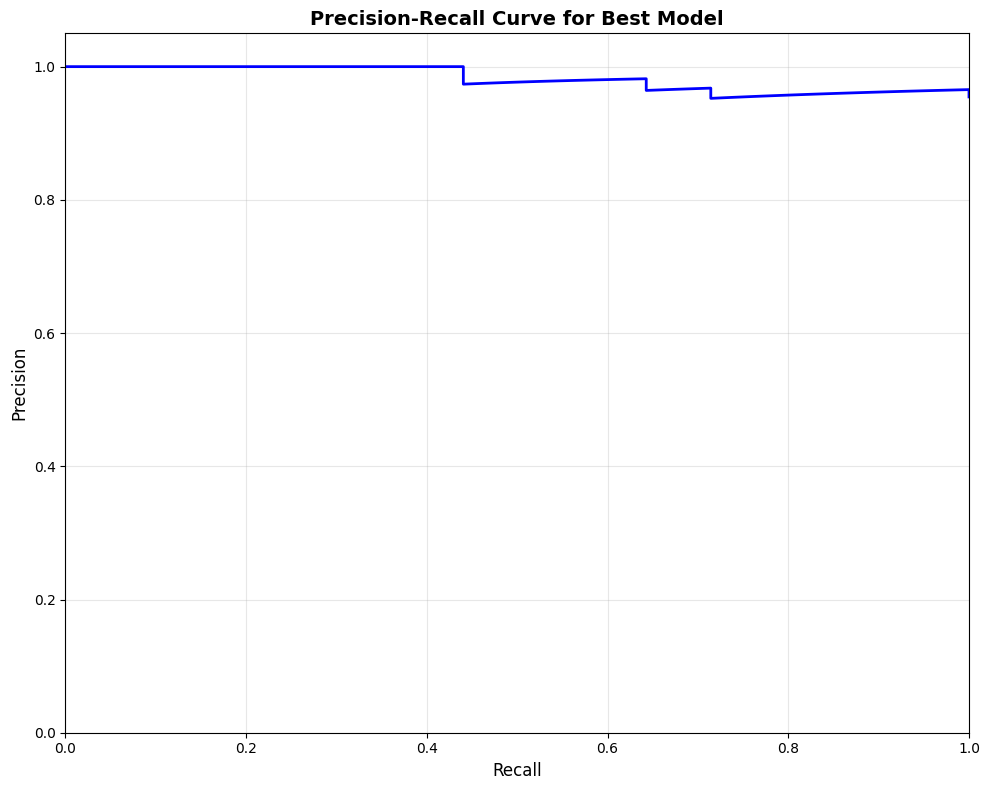

In [34]:
def plot_precision_recall_curve(y_true, reconstruction_errors):
    """
    Plot Precision-Recall curve for the best model.
    
    Args:
        y_true: True binary labels
        reconstruction_errors: Reconstruction errors for test set
    """
    precision, recall, thresholds = precision_recall_curve(y_true, reconstruction_errors)
    
    plt.figure(figsize=(10, 8))
    plt.plot(recall, precision, linewidth=2, color='blue')
    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.title('Precision-Recall Curve for Best Model', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.tight_layout()
    plt.show()

# Plot PR curve for best model
plot_precision_recall_curve(y_test_binary, best_evaluator.reconstruction_errors)